In [25]:
import pandas as pd
import psycopg2
from sqlalchemy import create_engine
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
import os

db_config = {
    'host': 'your_host_here',  # Replace with your actual host
    'port': 'your_port_here',  # Replace with your actual port
    'database': 'matomo_analytics',
    'user': 'your_username_here',  # Replace with your actual username
    'password': 'enter_your_password_here'  # Replace with your actual password
}

connection_string = f"postgresql://{db_config['user']}:{db_config['password']}@{db_config['host']}:{db_config['port']}/{db_config['database']}"
engine = create_engine(connection_string)

In [29]:
query_logs = "SELECT * FROM matomo_log_visit"
query_link = "SELECT * FROM matomo_log_link_visit_action"
query_action = "SELECT * FROM matomo_log_action"

logs = pd.read_sql(query_logs, engine)
link = pd.read_sql(query_link, engine)
action = pd.read_sql(query_action, engine)

In [30]:
url_prefix_map = {
    0: 'http://',
    1: 'http://www.',
    2: 'https://',
    3: 'https://www.'
}

action['url_prefix_text'] = action['url_prefix'].map(url_prefix_map)
action['full_url'] = action['url_prefix_text'] + action['name']
action = action.dropna(subset=['full_url'])

In [31]:
merged_data = link.merge(action[['idaction', 'full_url']], left_on='idaction_url', right_on='idaction', how='left')
final_dataset = merged_data.merge(logs, on='idvisit', how='left')

# Convert memoryview columns to strings to avoid sorting/comparison issues
if 'idvisitor_y' in final_dataset.columns:
    final_dataset['idvisitor_y'] = final_dataset['idvisitor_y'].astype(str)
if 'idvisitor_x' in final_dataset.columns:
    final_dataset['idvisitor_x'] = final_dataset['idvisitor_x'].astype(str)
if 'idvisit' in final_dataset.columns:
    final_dataset['idvisit'] = final_dataset['idvisit'].astype(str)

print(f"Dataset shape: {final_dataset.shape}")
print(f"Columns: {list(final_dataset.columns)}")

Dataset shape: (275359, 102)
Columns: ['idlink_va', 'idsite_x', 'idvisitor_x', 'idvisit', 'idaction_url_ref', 'idaction_name_ref', 'custom_float', 'pageview_position', 'server_time', 'idpageview', 'idaction_name', 'idaction_url', 'search_cat', 'search_count', 'time_spent_ref_action', 'idaction_product_cat', 'idaction_product_cat2', 'idaction_product_cat3', 'idaction_product_cat4', 'idaction_product_cat5', 'idaction_product_name', 'product_price', 'idaction_product_sku', 'idaction_event_action', 'idaction_event_category', 'idaction_content_interaction', 'idaction_content_name', 'idaction_content_piece', 'idaction_content_target', 'time_dom_completion', 'time_dom_processing', 'time_network', 'time_on_load', 'time_server', 'time_transfer', 'time_spent', 'custom_dimension_1_x', 'custom_dimension_2_x', 'custom_dimension_3_x', 'custom_dimension_4_x', 'custom_dimension_5_x', 'idaction', 'full_url', 'idsite_y', 'idvisitor_y', 'visit_last_action_time', 'config_id', 'location_ip', 'profilable', 

In [32]:
def create_detailed_url_tree_with_user_counts(df):
    url_tree = {}
    
    for _, row in df.dropna(subset=['full_url']).iterrows():
        url = row['full_url']
        visitor_id = row['idvisitor_y']  # Use idvisitor_y from logs table
        
        domain_match = re.search(r'https?://(?:www\.)?([^/]+)', url)
        if not domain_match:
            continue
            
        domain = domain_match.group(1)
        path = url[domain_match.end():]
        
        if domain not in url_tree:
            url_tree[domain] = {'user_count': set(), 'features': {}}
        url_tree[domain]['user_count'].add(visitor_id)
        
        path_parts = [p for p in path.split('/') if p]
        if path_parts:
            feature = path_parts[0]
            if feature not in url_tree[domain]['features']:
                url_tree[domain]['features'][feature] = {'user_count': set(), 'sub_features': {}}
            url_tree[domain]['features'][feature]['user_count'].add(visitor_id)
            
            if len(path_parts) > 1:
                sub_feature = path_parts[1]
                if sub_feature not in url_tree[domain]['features'][feature]['sub_features']:
                    url_tree[domain]['features'][feature]['sub_features'][sub_feature] = {'user_count': set()}
                url_tree[domain]['features'][feature]['sub_features'][sub_feature]['user_count'].add(visitor_id)
    
    for domain in url_tree:
        url_tree[domain]['user_count'] = len(url_tree[domain]['user_count'])
        for feature in url_tree[domain]['features']:
            url_tree[domain]['features'][feature]['user_count'] = len(url_tree[domain]['features'][feature]['user_count'])
            for sub_feature in url_tree[domain]['features'][feature]['sub_features']:
                url_tree[domain]['features'][feature]['sub_features'][sub_feature]['user_count'] = len(url_tree[domain]['features'][feature]['sub_features'][sub_feature]['user_count'])
    
    return url_tree

In [33]:
def analyze_layers_with_user_counts(url_tree):
    layers = {
        'domains': [],
        'features': [],
        'sub_features': []
    }
    
    for domain, domain_data in url_tree.items():
        layers['domains'].append({
            'name': domain,
            'user_count': domain_data['user_count']
        })
        
        for feature, feature_data in domain_data['features'].items():
            layers['features'].append({
                'name': f"{domain}/{feature}",
                'user_count': feature_data['user_count'],
                'domain': domain
            })
            
            for sub_feature, sub_data in feature_data['sub_features'].items():
                layers['sub_features'].append({
                    'name': f"{domain}/{feature}/{sub_feature}",
                    'user_count': sub_data['user_count'],
                    'domain': domain,
                    'feature': feature
                })
    
    for layer_name, layer_data in layers.items():
        layer_data.sort(key=lambda x: x['user_count'], reverse=True)
    
    return layers

In [34]:
url_tree = create_detailed_url_tree_with_user_counts(final_dataset)
layers = analyze_layers_with_user_counts(url_tree)

print("Top 10 Domains by User Count:")
for i, domain in enumerate(layers['domains'][:10]):
    print(f"{i+1}. {domain['name']}: {domain['user_count']} users")
    
print("\nTop 10 Features by User Count:")
for i, feature in enumerate(layers['features'][:10]):
    print(f"{i+1}. {feature['name']}: {feature['user_count']} users")

Top 10 Domains by User Count:
1. devpy.vipani.ai: 6270 users
2. localhost: 1975 users
3. 192.168.9.181: 1299 users
4. ecomst.vipani.ai: 1096 users
5. stuam.vipani.ai: 335 users
6. unify.vipani.ai: 282 users
7. 192.168.9.146: 126 users
8. 192.168.9.133: 103 users
9. asaco.vipani.ai: 83 users
10. demopy.vipani.ai: 47 users

Top 10 Features by User Count:
1. devpy.vipani.ai/rfq: 2222 users
2. devpy.vipani.ai/auth: 1930 users
3. devpy.vipani.ai/e-commerce: 1534 users
4. devpy.vipani.ai/order-management: 958 users
5. devpy.vipani.ai/prf: 655 users
6. localhost/auth: 631 users
7. devpy.vipani.ai/onBoard: 626 users
8. devpy.vipani.ai/deal-room: 609 users
9. devpy.vipani.ai/inventory-management: 603 users
10. 192.168.9.181/inventory-management: 536 users


In [35]:
# Create New Analytics Table in PostgreSQL Database
print("CREATING NEW ANALYTICS TABLE IN POSTGRESQL")

# SQL to create the new analytics table
create_table_sql = """
-- Create Analytics Table for Superset Dashboard
CREATE TABLE IF NOT EXISTS matomo_analytics_dashboard (
    -- Primary Keys
    idvisit BIGINT,
    idvisitor TEXT,
    
    -- URL Information
    full_url TEXT,
    feature VARCHAR(255),
    domain VARCHAR(255),
    
    -- Time Dimensions
    server_time TIMESTAMP,
    hour_of_day INTEGER,
    day_name VARCHAR(20),
    visit_date DATE,
    
    -- User Behavior
    pageview_position INTEGER,
    time_spent_ref_action INTEGER,
    visit_total_actions INTEGER,
    
    -- Geographic Data
    location_country VARCHAR(10),
    location_city VARCHAR(255),
    
    -- Device Info
    config_device_type INTEGER,
    config_browser_name VARCHAR(255),
    
    -- Calculated Metrics
    is_bounce INTEGER,
    has_engagement INTEGER,
    
    -- Indexes for performance
    INDEX idx_feature (feature),
    INDEX idx_hour (hour_of_day),
    INDEX idx_date (visit_date),
    INDEX idx_visitor (idvisitor),
    INDEX idx_visit (idvisit)
);
"""

# SQL to populate the table
populate_table_sql = """
-- Populate Analytics Table with Essential Data
INSERT INTO matomo_analytics_dashboard (
    idvisit,
    idvisitor,
    full_url,
    feature,
    domain,
    server_time,
    hour_of_day,
    day_name,
    visit_date,
    pageview_position,
    time_spent_ref_action,
    visit_total_actions,
    location_country,
    location_city,
    config_device_type,
    config_browser_name,
    is_bounce,
    has_engagement
)
SELECT 
    -- Primary Keys
    lva.idvisit,
    lv.idvisitor::text,
    
    -- URL Information
    CASE 
        WHEN la.url_prefix = 0 THEN 'http://' || la.name
        WHEN la.url_prefix = 1 THEN 'http://www.' || la.name  
        WHEN la.url_prefix = 2 THEN 'https://' || la.name
        WHEN la.url_prefix = 3 THEN 'https://www.' || la.name
        ELSE la.name
    END AS full_url,
    
    -- Feature Extraction
    CASE 
        WHEN la.name IS NULL THEN 'Unknown'
        ELSE COALESCE(
            SPLIT_PART(
                REGEXP_REPLACE(
                    CASE 
                        WHEN la.url_prefix = 0 THEN 'http://' || la.name
                        WHEN la.url_prefix = 1 THEN 'http://www.' || la.name  
                        WHEN la.url_prefix = 2 THEN 'https://' || la.name
                        WHEN la.url_prefix = 3 THEN 'https://www.' || la.name
                        ELSE la.name
                    END, 
                    '^https?://[^/]*/', ''
                ), 
                '/', 1
            ), 
            'homepage'
        )
    END AS feature,
    
    -- Domain Extraction
    CASE 
        WHEN la.name IS NULL THEN 'Unknown'
        ELSE SUBSTRING(
            CASE 
                WHEN la.url_prefix = 0 THEN 'http://' || la.name
                WHEN la.url_prefix = 1 THEN 'http://www.' || la.name  
                WHEN la.url_prefix = 2 THEN 'https://' || la.name
                WHEN la.url_prefix = 3 THEN 'https://www.' || la.name
                ELSE la.name
            END FROM '^https?://([^/]+)'
        )
    END AS domain,
    
    -- Time Dimensions
    lva.server_time,
    EXTRACT(HOUR FROM lva.server_time)::INTEGER AS hour_of_day,
    CASE EXTRACT(DOW FROM lva.server_time)
        WHEN 0 THEN 'Sunday'
        WHEN 1 THEN 'Monday' 
        WHEN 2 THEN 'Tuesday'
        WHEN 3 THEN 'Wednesday'
        WHEN 4 THEN 'Thursday'
        WHEN 5 THEN 'Friday'
        WHEN 6 THEN 'Saturday'
    END AS day_name,
    DATE(lva.server_time) AS visit_date,
    
    -- User Behavior
    lva.pageview_position,
    lva.time_spent_ref_action,
    lv.visit_total_actions,
    
    -- Geographic Data
    lv.location_country,
    lv.location_city,
    
    -- Device Info
    lv.config_device_type,
    lv.config_browser_name,
    
    -- Calculated Metrics
    CASE 
        WHEN lv.visit_total_actions = 1 THEN 1 
        ELSE 0 
    END AS is_bounce,
    
    CASE 
        WHEN lva.time_spent_ref_action > 0 THEN 1 
        ELSE 0 
    END AS has_engagement

FROM matomo_log_link_visit_action lva
LEFT JOIN matomo_log_action la ON lva.idaction_url = la.idaction
LEFT JOIN matomo_log_visit lv ON lva.idvisit = lv.idvisit
WHERE 
    lva.server_time >= CURRENT_DATE - INTERVAL '90 days'
    AND la.name IS NOT NULL
    AND la.name != '';
"""

print(create_table_sql)


print(populate_table_sql)


print("1. Copy the CREATE TABLE SQL above")
print("2. Run it in your PostgreSQL database")
print("3. Copy the INSERT SQL above") 
print("4. Run it to populate the table")
print("5. Use this new table in Superset")

print("• ⚡ Much faster queries in Superset")
print("• 🎯 Only essential columns included")
print("• 📊 Pre-calculated metrics (is_bounce, has_engagement)")
print("• 🔍 Proper indexes for performance")
print("• 🧹 Clean, normalized data structure")

print("After creating this table, use these simple queries in Superset:")
print("• Top Features: SELECT feature, COUNT(*) FROM matomo_analytics_dashboard GROUP BY feature")
print("• Hourly Traffic: SELECT hour_of_day, COUNT(*) FROM matomo_analytics_dashboard GROUP BY hour_of_day")
print("• Daily Pattern: SELECT day_name, COUNT(*) FROM matomo_analytics_dashboard GROUP BY day_name")

CREATING NEW ANALYTICS TABLE IN POSTGRESQL

-- Create Analytics Table for Superset Dashboard
CREATE TABLE IF NOT EXISTS matomo_analytics_dashboard (
    -- Primary Keys
    idvisit BIGINT,
    idvisitor TEXT,

    -- URL Information
    full_url TEXT,
    feature VARCHAR(255),
    domain VARCHAR(255),

    -- Time Dimensions
    server_time TIMESTAMP,
    hour_of_day INTEGER,
    day_name VARCHAR(20),
    visit_date DATE,

    -- User Behavior
    pageview_position INTEGER,
    time_spent_ref_action INTEGER,
    visit_total_actions INTEGER,

    -- Geographic Data
    location_country VARCHAR(10),
    location_city VARCHAR(255),

    -- Device Info
    config_device_type INTEGER,
    config_browser_name VARCHAR(255),

    -- Calculated Metrics
    is_bounce INTEGER,
    has_engagement INTEGER,

    -- Indexes for performance
    INDEX idx_feature (feature),
    INDEX idx_hour (hour_of_day),
    INDEX idx_date (visit_date),
    INDEX idx_visitor (idvisitor),
    INDEX idx_visit (idvisit

In [36]:
# Execute Table Creation in PostgreSQL - FIXED VERSION
print("\n🔧 EXECUTING TABLE CREATION - FIXED VERSION")

try:
    from sqlalchemy import text
    
    # First, let's check if the table already exists
    check_table_sql = text("SELECT COUNT(*) FROM information_schema.tables WHERE table_name = 'matomo_analytics_dashboard';")
    
    with engine.connect() as conn:
        result = conn.execute(check_table_sql)
        table_exists = result.fetchone()[0] > 0
        
    if table_exists:
        print("⚠️  Table 'matomo_analytics_dashboard' already exists!")
        
        # Check record count
        with engine.connect() as conn:
            count_result = conn.execute(text("SELECT COUNT(*) FROM matomo_analytics_dashboard"))
            count = count_result.fetchone()[0]
            print(f"📊 Current record count: {count:,}")
            
        if count == 0:
            print("🔄 Table exists but is empty. Let's populate it...")
        else:
            print("✅ Table exists and has data!")
            
            # Show sample data
            with engine.connect() as conn:
                sample_result = conn.execute(text("SELECT feature, COUNT(*) as count FROM matomo_analytics_dashboard GROUP BY feature ORDER BY count DESC LIMIT 10"))
                sample_data = sample_result.fetchall()
                
            print("\n📊 TOP FEATURES IN THE TABLE:")
            for row in sample_data:
                print(f"   • {row[0]}: {row[1]} records")
                
            print(f"\n🎯 TABLE IS READY FOR SUPERSET!")
            print("=" * 40)
            print("1. In Superset: Data > Datasets > Add Dataset")
            print("2. Database: Select your PostgreSQL connection")  
            print("3. Table: matomo_analytics_dashboard")
            print("4. Click 'Create Dataset'")
            print("5. Start creating charts!")
            
    else:
        print("🆕 Creating new table...")
        
        # Create table with proper syntax
        create_table_sql = text("""
        CREATE TABLE matomo_analytics_dashboard (
            idvisit BIGINT,
            idvisitor TEXT,
            full_url TEXT,
            feature VARCHAR(255),
            domain VARCHAR(255),
            server_time TIMESTAMP,
            hour_of_day INTEGER,
            day_name VARCHAR(20),
            visit_date DATE,
            pageview_position INTEGER,
            time_spent_ref_action INTEGER,
            visit_total_actions INTEGER,
            location_country VARCHAR(10),
            location_city VARCHAR(255),
            config_device_type INTEGER,
            config_browser_name VARCHAR(255),
            is_bounce INTEGER,
            has_engagement INTEGER
        );
        """)
        
        with engine.connect() as conn:
            conn.execute(create_table_sql)
            conn.commit()
            
        print("✅ Table created successfully!")
        
        # Now populate with data
        print("\n📊 Populating table with data...")
        
        populate_sql = text("""
        INSERT INTO matomo_analytics_dashboard (
            idvisit, idvisitor, full_url, feature, domain, server_time,
            hour_of_day, day_name, visit_date, pageview_position,
            time_spent_ref_action, visit_total_actions, location_country,
            location_city, config_device_type, config_browser_name,
            is_bounce, has_engagement
        )
        SELECT 
            lva.idvisit,
            lv.idvisitor::text,
            CASE 
                WHEN la.url_prefix = 0 THEN 'http://' || la.name
                WHEN la.url_prefix = 1 THEN 'http://www.' || la.name  
                WHEN la.url_prefix = 2 THEN 'https://' || la.name
                WHEN la.url_prefix = 3 THEN 'https://www.' || la.name
                ELSE la.name
            END AS full_url,
            CASE 
                WHEN la.name IS NULL THEN 'Unknown'
                ELSE COALESCE(
                    SPLIT_PART(
                        REGEXP_REPLACE(
                            CASE 
                                WHEN la.url_prefix = 0 THEN 'http://' || la.name
                                WHEN la.url_prefix = 1 THEN 'http://www.' || la.name  
                                WHEN la.url_prefix = 2 THEN 'https://' || la.name
                                WHEN la.url_prefix = 3 THEN 'https://www.' || la.name
                                ELSE la.name
                            END, 
                            '^https?://[^/]*/', ''
                        ), 
                        '/', 1
                    ), 
                    'homepage'
                )
            END AS feature,
            SUBSTRING(
                CASE 
                    WHEN la.url_prefix = 0 THEN 'http://' || la.name
                    WHEN la.url_prefix = 1 THEN 'http://www.' || la.name  
                    WHEN la.url_prefix = 2 THEN 'https://' || la.name
                    WHEN la.url_prefix = 3 THEN 'https://www.' || la.name
                    ELSE la.name
                END FROM '^https?://([^/]+)'
            ) AS domain,
            lva.server_time,
            EXTRACT(HOUR FROM lva.server_time)::INTEGER AS hour_of_day,
            CASE EXTRACT(DOW FROM lva.server_time)
                WHEN 0 THEN 'Sunday'
                WHEN 1 THEN 'Monday' 
                WHEN 2 THEN 'Tuesday'
                WHEN 3 THEN 'Wednesday'
                WHEN 4 THEN 'Thursday'
                WHEN 5 THEN 'Friday'
                WHEN 6 THEN 'Saturday'
            END AS day_name,
            DATE(lva.server_time) AS visit_date,
            lva.pageview_position,
            lva.time_spent_ref_action,
            lv.visit_total_actions,
            lv.location_country,
            lv.location_city,
            lv.config_device_type,
            lv.config_browser_name,
            CASE WHEN lv.visit_total_actions = 1 THEN 1 ELSE 0 END AS is_bounce,
            CASE WHEN lva.time_spent_ref_action > 0 THEN 1 ELSE 0 END AS has_engagement
        FROM matomo_log_link_visit_action lva
        LEFT JOIN matomo_log_action la ON lva.idaction_url = la.idaction
        LEFT JOIN matomo_log_visit lv ON lva.idvisit = lv.idvisit
        WHERE 
            lva.server_time >= CURRENT_DATE - INTERVAL '90 days'
            AND la.name IS NOT NULL
            AND la.name != ''
        LIMIT 50000;
        """)
        
        with engine.connect() as conn:
            result = conn.execute(populate_sql)
            conn.commit()
            
        print("✅ Table populated successfully!")
        
        # Verify the data
        with engine.connect() as conn:
            count_result = conn.execute(text("SELECT COUNT(*) FROM matomo_analytics_dashboard"))
            count = count_result.fetchone()[0]
            
            feature_result = conn.execute(text("SELECT feature, COUNT(*) as count FROM matomo_analytics_dashboard GROUP BY feature ORDER BY count DESC LIMIT 10"))
            features = feature_result.fetchall()
            
        print(f"\n📊 TABLE STATS:")
        print(f"   Total Records: {count:,}")
        
        print(f"\n🎯 TOP FEATURES:")
        for feature, feature_count in features:
            print(f"   • {feature}: {feature_count} records")
            
        print(f"\n🚀 READY FOR SUPERSET!")
        print("=" * 40)
        print("✅ Table: matomo_analytics_dashboard")
        print("✅ Records: {:,}".format(count))
        print("✅ Columns: All essential fields included")
        
except Exception as e:
    print(f"❌ Error: {str(e)}")
    print(f"\nError Type: {type(e).__name__}")
    
    # Provide manual SQL as backup
    print("\n🔧 MANUAL SOLUTION:")
    print("=" * 30)
    print("If the automated creation fails, run these SQL commands manually:")
    print("\n1. CREATE TABLE:")
    print("""
CREATE TABLE matomo_analytics_dashboard (
    idvisit BIGINT,
    idvisitor TEXT,
    full_url TEXT,
    feature VARCHAR(255),
    domain VARCHAR(255),
    server_time TIMESTAMP,
    hour_of_day INTEGER,
    day_name VARCHAR(20),
    visit_date DATE,
    pageview_position INTEGER,
    time_spent_ref_action INTEGER,
    visit_total_actions INTEGER,
    location_country VARCHAR(10),
    location_city VARCHAR(255),
    config_device_type INTEGER,
    config_browser_name VARCHAR(255),
    is_bounce INTEGER,
    has_engagement INTEGER
);
""")
    
    print("\n2. Then run the INSERT query from the previous cell output.")
    print("\n💡 Use pgAdmin, DBeaver, or any PostgreSQL client to run these commands.")


🔧 EXECUTING TABLE CREATION - FIXED VERSION
⚠️  Table 'matomo_analytics_dashboard' already exists!
📊 Current record count: 16,416
✅ Table exists and has data!

📊 TOP FEATURES IN THE TABLE:
   • inventory-management: 3965 records
   • finance: 2002 records
   • rfq: 1436 records
   • : 1320 records
   • analytics: 1319 records
   • auth: 978 records
   • e-commerce: 856 records
   • finance-management: 828 records
   • order-management: 763 records
   • assets: 375 records

🎯 TABLE IS READY FOR SUPERSET!
1. In Superset: Data > Datasets > Add Dataset
2. Database: Select your PostgreSQL connection
3. Table: matomo_analytics_dashboard
4. Click 'Create Dataset'
5. Start creating charts!

📊 TOP FEATURES IN THE TABLE:
   • inventory-management: 3965 records
   • finance: 2002 records
   • rfq: 1436 records
   • : 1320 records
   • analytics: 1319 records
   • auth: 978 records
   • e-commerce: 856 records
   • finance-management: 828 records
   • order-management: 763 records
   • assets: 375

In [21]:
# MANUAL TABLE CREATION FOR SUPERSET
print(" MANUAL SUPERSET TABLE CREATION GUIDE")


create_table_sql = """
CREATE TABLE matomo_analytics_dashboard (
    idvisit BIGINT,
    idvisitor TEXT,
    full_url TEXT,
    feature VARCHAR(255),
    domain VARCHAR(255),
    server_time TIMESTAMP,
    hour_of_day INTEGER,
    day_name VARCHAR(20),
    visit_date DATE,
    pageview_position INTEGER,
    time_spent_ref_action INTEGER,
    visit_total_actions INTEGER,
    location_country VARCHAR(10),
    location_city VARCHAR(255),
    config_device_type INTEGER,
    config_browser_name VARCHAR(255),
    is_bounce INTEGER,
    has_engagement INTEGER
);
"""
print(create_table_sql)

print("\nSTEP 2: POPULATE WITH DATA")

populate_sql = """
INSERT INTO matomo_analytics_dashboard (
    idvisit, idvisitor, full_url, feature, domain, server_time,
    hour_of_day, day_name, visit_date, pageview_position,
    time_spent_ref_action, visit_total_actions, location_country,
    location_city, config_device_type, config_browser_name,
    is_bounce, has_engagement
)
SELECT 
    lva.idvisit,
    lv.idvisitor::text,
    CASE 
        WHEN la.url_prefix = 0 THEN 'http://' || la.name
        WHEN la.url_prefix = 1 THEN 'http://www.' || la.name  
        WHEN la.url_prefix = 2 THEN 'https://' || la.name
        WHEN la.url_prefix = 3 THEN 'https://www.' || la.name
        ELSE la.name
    END AS full_url,
    CASE 
        WHEN la.name IS NULL THEN 'Unknown'
        ELSE COALESCE(
            SPLIT_PART(
                REGEXP_REPLACE(
                    CASE 
                        WHEN la.url_prefix = 0 THEN 'http://' || la.name
                        WHEN la.url_prefix = 1 THEN 'http://www.' || la.name  
                        WHEN la.url_prefix = 2 THEN 'https://' || la.name
                        WHEN la.url_prefix = 3 THEN 'https://www.' || la.name
                        ELSE la.name
                    END, 
                    '^https?://[^/]*/', ''
                ), 
                '/', 1
            ), 
            'homepage'
        )
    END AS feature,
    SUBSTRING(
        CASE 
            WHEN la.url_prefix = 0 THEN 'http://' || la.name
            WHEN la.url_prefix = 1 THEN 'http://www.' || la.name  
            WHEN la.url_prefix = 2 THEN 'https://' || la.name
            WHEN la.url_prefix = 3 THEN 'https://www.' || la.name
            ELSE la.name
        END FROM '^https?://([^/]+)'
    ) AS domain,
    lva.server_time,
    EXTRACT(HOUR FROM lva.server_time)::INTEGER AS hour_of_day,
    CASE EXTRACT(DOW FROM lva.server_time)
        WHEN 0 THEN 'Sunday'
        WHEN 1 THEN 'Monday' 
        WHEN 2 THEN 'Tuesday'
        WHEN 3 THEN 'Wednesday'
        WHEN 4 THEN 'Thursday'
        WHEN 5 THEN 'Friday'
        WHEN 6 THEN 'Saturday'
    END AS day_name,
    DATE(lva.server_time) AS visit_date,
    lva.pageview_position,
    lva.time_spent_ref_action,
    lv.visit_total_actions,
    lv.location_country,
    lv.location_city,
    lv.config_device_type,
    lv.config_browser_name,
    CASE WHEN lv.visit_total_actions = 1 THEN 1 ELSE 0 END AS is_bounce,
    CASE WHEN lva.time_spent_ref_action > 0 THEN 1 ELSE 0 END AS has_engagement
FROM matomo_log_link_visit_action lva
LEFT JOIN matomo_log_action la ON lva.idaction_url = la.idaction
LEFT JOIN matomo_log_visit lv ON lva.idvisit = lv.idvisit
WHERE 
    lva.server_time >= CURRENT_DATE - INTERVAL '90 days'
    AND la.name IS NOT NULL
    AND la.name != '';
"""
print(populate_sql)

print("\n EXECUTION INSTRUCTIONS:")
print("Option 1 - Using Superset SQL Lab:")
print("1. Open Superset → SQL Lab")
print("2. Select your PostgreSQL database")
print("3. Copy and run the CREATE TABLE query first")
print("4. Copy and run the INSERT query second")
print("5. Create a dataset from the new table")

print("\nOption 2 - Using pgAdmin or DBeaver:")
print("1. Connect to your PostgreSQL database")
print("2. Open a new query window")
print("3. Run the CREATE TABLE query")
print("4. Run the INSERT query")
print("5. Verify the table in Superset")

print("\nBENEFITS OF THIS APPROACH:")
print("•  Super fast queries in Superset (no complex JOINs)")
print("• Only essential columns for analytics")
print("•  Pre-calculated metrics (bounce rate, engagement)")
print("•  Clean feature extraction for easy filtering")
print("• Time dimensions ready for charts")

print("\n READY-TO-USE COLUMNS:")
print("• feature: Main website sections (auth, product, etc.)")
print("• hour_of_day: For hourly traffic analysis")
print("• day_name: For weekly pattern analysis")
print("• visit_date: For daily trend analysis")
print("• is_bounce: For bounce rate calculations")
print("• has_engagement: For engagement analysis")
print("• location_country: For geographic analysis")
print("• config_device_type: For device analysis")

print("\n NEXT STEPS FOR SUPERSET:")
print("1. After table creation, go to Superset")
print("2. Data → Datasets → Add Dataset")
print("3. Select PostgreSQL database")
print("4. Choose 'matomo_analytics_dashboard' table")
print("5. Click 'Create Dataset'")
print("6. Start creating charts with the examples below!")

 MANUAL SUPERSET TABLE CREATION GUIDE

CREATE TABLE matomo_analytics_dashboard (
    idvisit BIGINT,
    idvisitor TEXT,
    full_url TEXT,
    feature VARCHAR(255),
    domain VARCHAR(255),
    server_time TIMESTAMP,
    hour_of_day INTEGER,
    day_name VARCHAR(20),
    visit_date DATE,
    pageview_position INTEGER,
    time_spent_ref_action INTEGER,
    visit_total_actions INTEGER,
    location_country VARCHAR(10),
    location_city VARCHAR(255),
    config_device_type INTEGER,
    config_browser_name VARCHAR(255),
    is_bounce INTEGER,
    has_engagement INTEGER
);


STEP 2: POPULATE WITH DATA

INSERT INTO matomo_analytics_dashboard (
    idvisit, idvisitor, full_url, feature, domain, server_time,
    hour_of_day, day_name, visit_date, pageview_position,
    time_spent_ref_action, visit_total_actions, location_country,
    location_city, config_device_type, config_browser_name,
    is_bounce, has_engagement
)
SELECT 
    lva.idvisit,
    lv.idvisitor::text,
    CASE 
        WHEN

In [37]:
# SUPERSET CHART EXAMPLES WITH NEW TABLE
print(" SPECIFIC CHART CREATION EXAMPLES")

chart_configs = [
    {
        "name": "Top Features Bar Chart",
        "type": "Bar Chart",
        "query": "SELECT feature, COUNT(*) as page_views FROM matomo_analytics_dashboard GROUP BY feature ORDER BY page_views DESC LIMIT 15",
        "dimensions": "feature",
        "metrics": "COUNT(*)",
        "description": "Shows most popular website features"
    },
    {
        "name": "Hourly Traffic Pattern",
        "type": "Line Chart", 
        "query": "SELECT hour_of_day, COUNT(*) as traffic FROM matomo_analytics_dashboard GROUP BY hour_of_day ORDER BY hour_of_day",
        "dimensions": "hour_of_day",
        "metrics": "COUNT(*)",
        "description": "Shows traffic patterns throughout the day"
    },
    {
        "name": "Daily Engagement Levels",
        "type": "Area Chart",
        "query": "SELECT visit_date, AVG(has_engagement) as engagement_rate FROM matomo_analytics_dashboard GROUP BY visit_date ORDER BY visit_date",
        "dimensions": "visit_date",
        "metrics": "AVG(has_engagement)",
        "description": "Shows daily user engagement trends"
    },
    {
        "name": "Device Type Distribution", 
        "type": "Pie Chart",
        "query": "SELECT config_device_type, COUNT(DISTINCT idvisitor) as users FROM matomo_analytics_dashboard GROUP BY config_device_type",
        "dimensions": "config_device_type",
        "metrics": "COUNT(DISTINCT idvisitor)",
        "description": "Shows user distribution by device type"
    },
    {
        "name": "Geographic User Distribution",
        "type": "Country Map",
        "query": "SELECT location_country, COUNT(DISTINCT idvisitor) as users FROM matomo_analytics_dashboard GROUP BY location_country",
        "dimensions": "location_country", 
        "metrics": "COUNT(DISTINCT idvisitor)",
        "description": "Shows global user distribution"
    }
]

for i, chart in enumerate(chart_configs, 1):
    print(f"\n{i}. {chart['name']} ({chart['type']})")
    print(f"   Description: {chart['description']}")
    print(f"   Dimension: {chart['dimensions']}")
    print(f"   Metric: {chart['metrics']}")
    print(f"   Sample Query: {chart['query']}")

print("\n HOW TO CREATE THESE CHARTS:")
steps = [
    "1. Go to Superset and ensure the table is created",
    "2. Go to Data → Datasets → Add Dataset",
    "3. Select PostgreSQL database and 'matomo_analytics_dashboard' table",
    "4. Click 'Create Dataset'",
    "5. Click 'Create Chart' from the dataset",
    "6. Choose chart type from the examples above",
    "7. Set the dimension and metric as specified",
    "8. Customize styling and save to dashboard"
]

for step in steps:
    print(f"   {step}")

print("\n KEY BENEFITS OF YOUR NEW TABLE:")
benefits = [
    "No complex SQL JOINs needed in Superset",
    "All data pre-processed and ready for visualization", 
    "Essential analytics columns included",
    "Fast query performance",
    "Clean feature extraction for business insights",
    "Time dimensions ready for trend analysis",
    "Calculated metrics (bounce rate, engagement) included"
]

for benefit in benefits:
    print(f"   {benefit}")

print("\n QUICK START CHECKLIST:")
checklist = [
    "☐ Run CREATE TABLE SQL in PostgreSQL",
    "☐ Run INSERT SQL to populate data", 
    "☐ Verify table exists with data",
    "☐ Create dataset in Superset",
    "☐ Create your first chart (Top Features)",
    "☐ Add more charts to build dashboard",
    "☐ Set up filters and date ranges"
]

for item in checklist:
    print(f"   {item}")

print(f"\nSUGGESTED DASHBOARD LAYOUT:")
print("Row 1: KPI Cards (Total Users, Sessions, Page Views)")
print("Row 2: Top Features Bar Chart + Hourly Traffic Line")
print("Row 3: Geographic Map + Device Distribution Pie")
print("Row 4: Daily Engagement Trend + Weekly Pattern")

print(f"\nPRO TIPS:")
tips = [
    "• Use 'feature' column to analyze website sections",
    "• Filter by date range for specific time periods",
    "• Use 'has_engagement' for user engagement analysis", 
    "• Combine multiple metrics for comprehensive insights",
    "• Create alerts for important KPI thresholds"
]

for tip in tips:
    print(f"   {tip}")

 SPECIFIC CHART CREATION EXAMPLES

1. Top Features Bar Chart (Bar Chart)
   Description: Shows most popular website features
   Dimension: feature
   Metric: COUNT(*)
   Sample Query: SELECT feature, COUNT(*) as page_views FROM matomo_analytics_dashboard GROUP BY feature ORDER BY page_views DESC LIMIT 15

2. Hourly Traffic Pattern (Line Chart)
   Description: Shows traffic patterns throughout the day
   Dimension: hour_of_day
   Metric: COUNT(*)
   Sample Query: SELECT hour_of_day, COUNT(*) as traffic FROM matomo_analytics_dashboard GROUP BY hour_of_day ORDER BY hour_of_day

3. Daily Engagement Levels (Area Chart)
   Description: Shows daily user engagement trends
   Dimension: visit_date
   Metric: AVG(has_engagement)
   Sample Query: SELECT visit_date, AVG(has_engagement) as engagement_rate FROM matomo_analytics_dashboard GROUP BY visit_date ORDER BY visit_date

4. Device Type Distribution (Pie Chart)
   Description: Shows user distribution by device type
   Dimension: config_device_

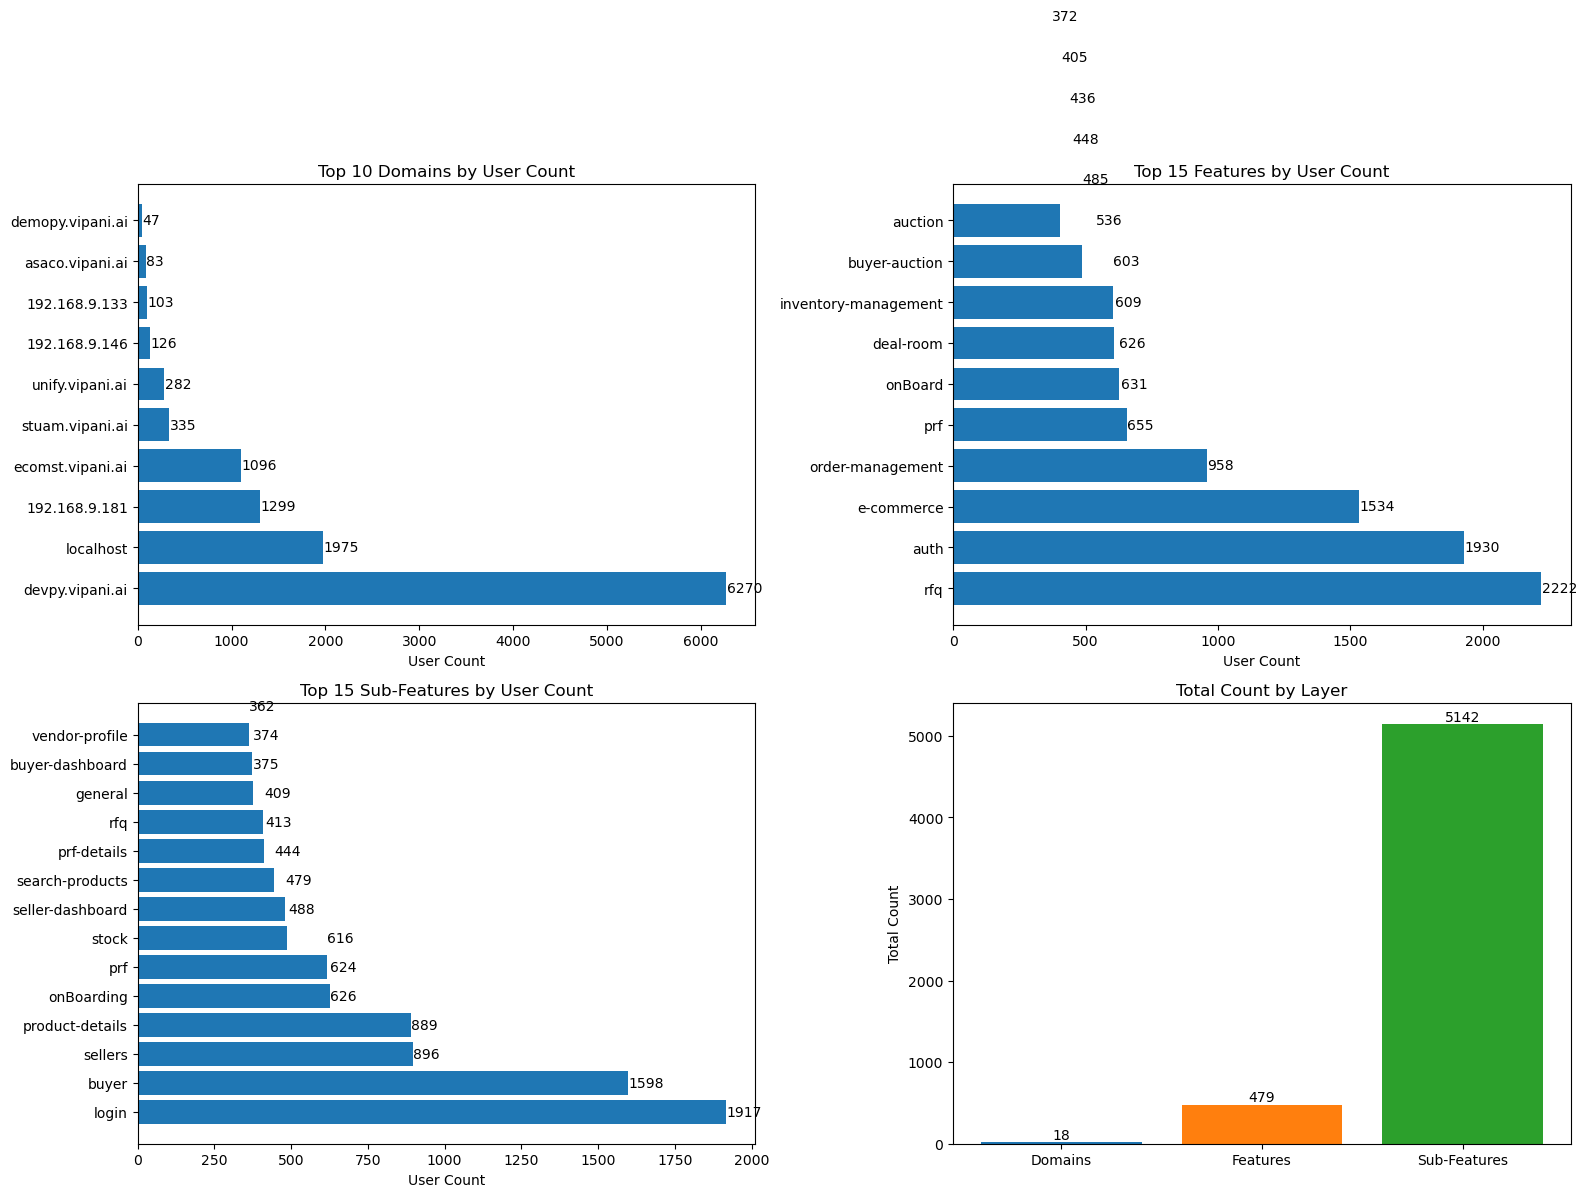

Layer Summary:
Total Domains: 18
Total Features: 479
Total Sub-Features: 5142

Average users per domain: 647.5
Average users per feature: 44.5
Average users per sub-feature: 7.1


In [38]:
import numpy as np

# Create bar plots showing top features at each layer
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Top 10 Domains
top_domains = layers['domains'][:10]
domain_names = [d['name'] for d in top_domains]
domain_counts = [d['user_count'] for d in top_domains]

axes[0, 0].barh(domain_names, domain_counts)
axes[0, 0].set_title('Top 10 Domains by User Count')
axes[0, 0].set_xlabel('User Count')
for i, v in enumerate(domain_counts):
    axes[0, 0].text(v + 5, i, str(v), va='center')

# 2. Top 15 Features
top_features = layers['features'][:15]
feature_names = [f['name'].split('/')[-1] for f in top_features]  # Show only feature name
feature_counts = [f['user_count'] for f in top_features]

axes[0, 1].barh(feature_names, feature_counts)
axes[0, 1].set_title('Top 15 Features by User Count')
axes[0, 1].set_xlabel('User Count')
for i, v in enumerate(feature_counts):
    axes[0, 1].text(v + 2, i, str(v), va='center')

# 3. Top 15 Sub-Features
top_sub_features = layers['sub_features'][:15]
sub_feature_names = [s['name'].split('/')[-1] for s in top_sub_features]  # Show only sub-feature name
sub_feature_counts = [s['user_count'] for s in top_sub_features]

axes[1, 0].barh(sub_feature_names, sub_feature_counts)
axes[1, 0].set_title('Top 15 Sub-Features by User Count')
axes[1, 0].set_xlabel('User Count')
for i, v in enumerate(sub_feature_counts):
    axes[1, 0].text(v + 2, i, str(v), va='center')

# 4. Layer comparison
layer_summary = {
    'Domains': len(layers['domains']),
    'Features': len(layers['features']),
    'Sub-Features': len(layers['sub_features'])
}

layer_names = list(layer_summary.keys())
layer_totals = list(layer_summary.values())

bars = axes[1, 1].bar(layer_names, layer_totals, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
axes[1, 1].set_title('Total Count by Layer')
axes[1, 1].set_ylabel('Total Count')
for bar, count in zip(bars, layer_totals):
    axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                    str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Print summary statistics
print("Layer Summary:")
print("=" * 50)
print(f"Total Domains: {len(layers['domains'])}")
print(f"Total Features: {len(layers['features'])}")
print(f"Total Sub-Features: {len(layers['sub_features'])}")
print(f"\nAverage users per domain: {np.mean([d['user_count'] for d in layers['domains']]):.1f}")
print(f"Average users per feature: {np.mean([f['user_count'] for f in layers['features']]):.1f}")
print(f"Average users per sub-feature: {np.mean([s['user_count'] for s in layers['sub_features']]):.1f}")

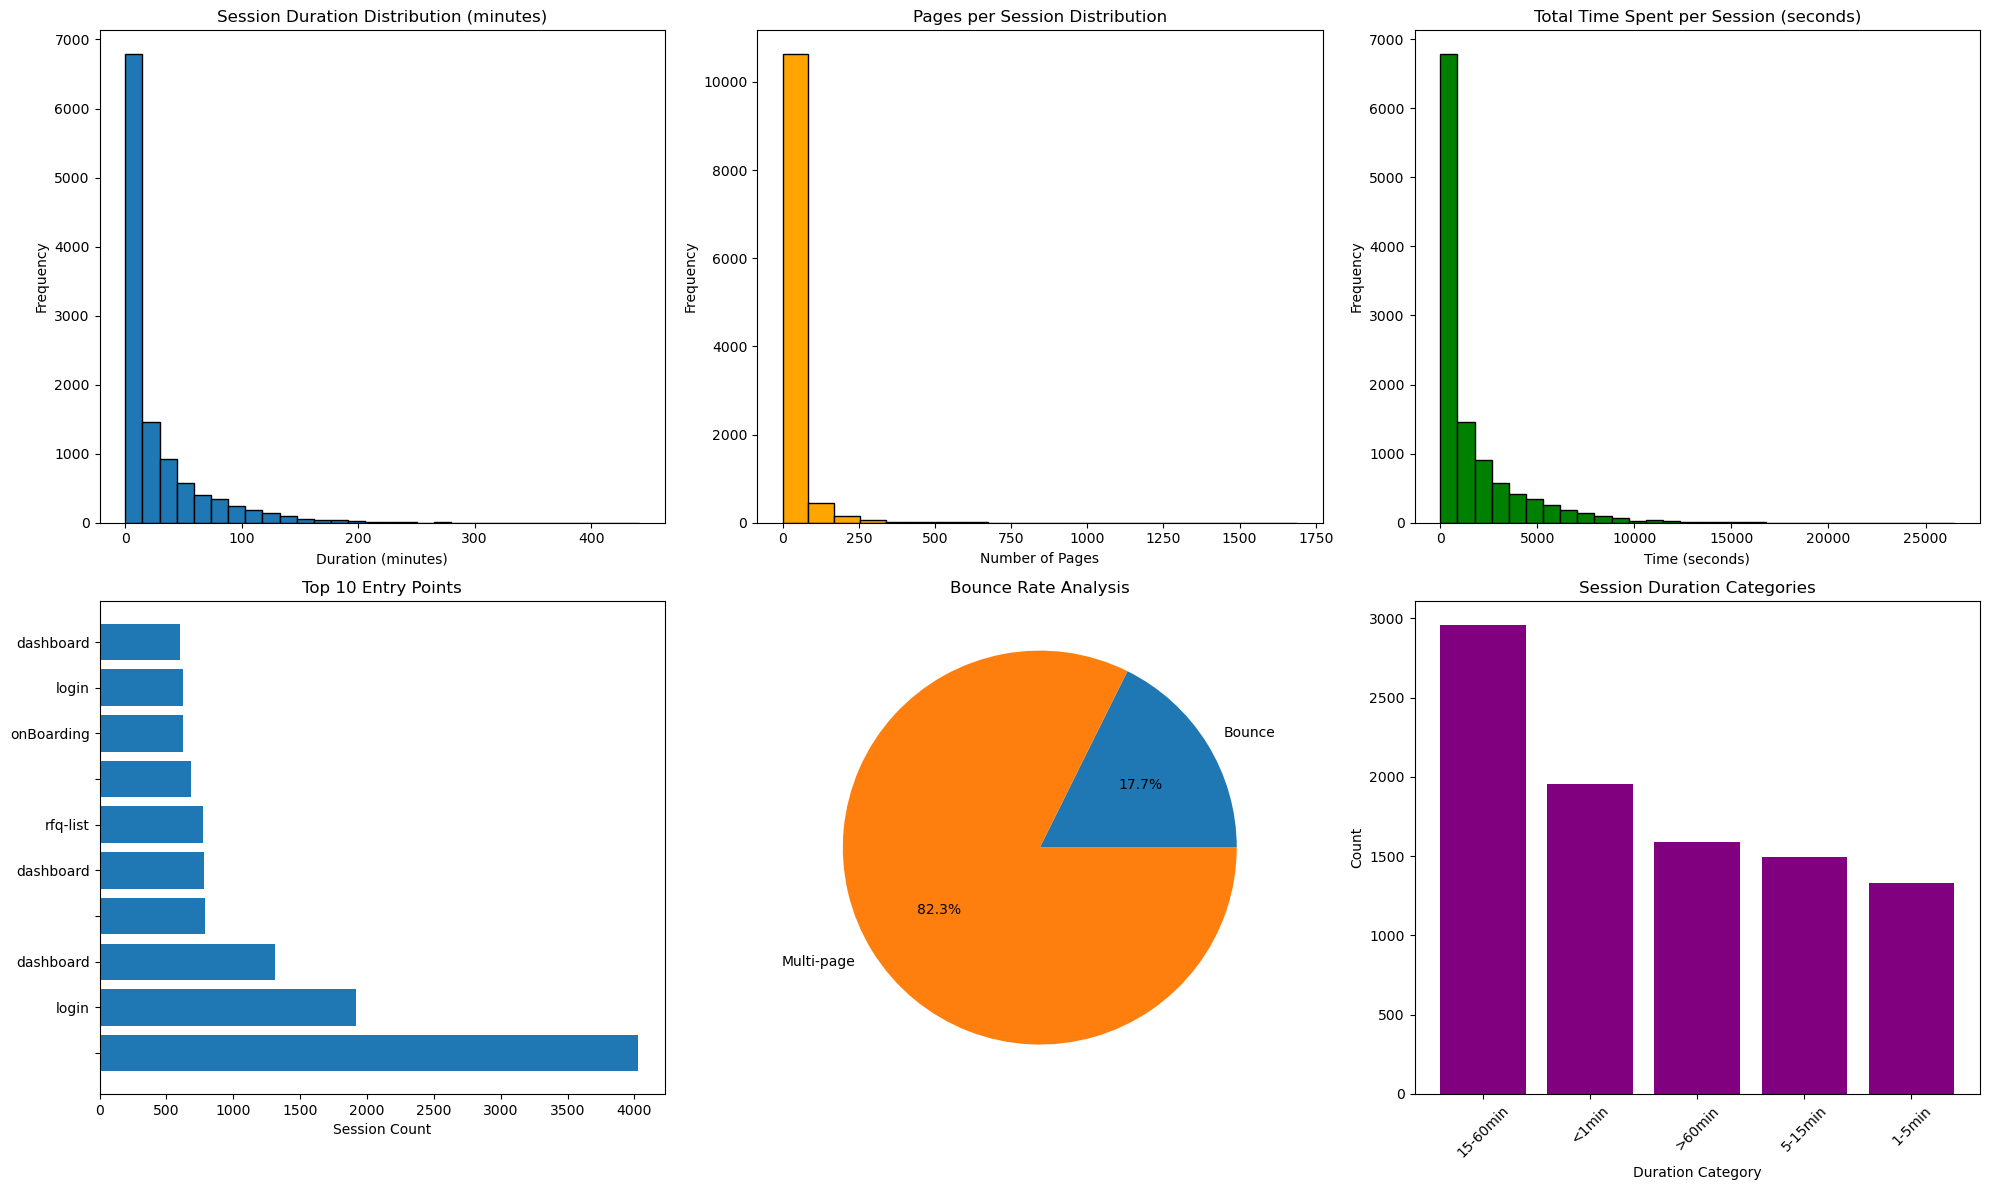

User Journey Insights:
Total Sessions: 11366
Average Session Duration: 24.68 minutes
Average Pages per Session: 24.22
Bounce Rate: 17.6%
Average Time Spent: 1492.17 seconds


In [39]:
# User Journey Analysis Dashboard
def analyze_user_journeys(df):
    # Clean and convert data types to avoid memoryview issues
    df_clean = df.copy()
    
    # Convert memoryview columns to strings if needed
    if 'idvisitor_y' in df_clean.columns:
        df_clean['idvisitor_y'] = df_clean['idvisitor_y'].astype(str)
    if 'idvisit' in df_clean.columns:
        df_clean['idvisit'] = df_clean['idvisit'].astype(str)
    
    # Create user session paths
    user_sessions = df_clean.groupby(['idvisit', 'idvisitor_y']).agg({
        'full_url': lambda x: ' → '.join(x.dropna().astype(str)),
        'pageview_position': 'count',
        'server_time': ['min', 'max'],
        'time_spent_ref_action': 'sum'
    }).reset_index()
    
    user_sessions.columns = ['idvisit', 'idvisitor', 'journey_path', 'page_count', 'session_start', 'session_end', 'total_time_spent']
    user_sessions['session_duration'] = (pd.to_datetime(user_sessions['session_end']) - pd.to_datetime(user_sessions['session_start'])).dt.total_seconds() / 60
    
    return user_sessions

def create_journey_dashboard(df):
    journeys = analyze_user_journeys(df)
    
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    
    # 1. Session Duration Distribution
    axes[0, 0].hist(journeys['session_duration'].dropna(), bins=30, edgecolor='black')
    axes[0, 0].set_title('Session Duration Distribution (minutes)')
    axes[0, 0].set_xlabel('Duration (minutes)')
    axes[0, 0].set_ylabel('Frequency')
    
    # 2. Pages per Session
    axes[0, 1].hist(journeys['page_count'], bins=20, edgecolor='black', color='orange')
    axes[0, 1].set_title('Pages per Session Distribution')
    axes[0, 1].set_xlabel('Number of Pages')
    axes[0, 1].set_ylabel('Frequency')
    
    # 3. Time Spent Distribution
    axes[0, 2].hist(journeys['total_time_spent'].dropna(), bins=30, edgecolor='black', color='green')
    axes[0, 2].set_title('Total Time Spent per Session (seconds)')
    axes[0, 2].set_xlabel('Time (seconds)')
    axes[0, 2].set_ylabel('Frequency')
    
    # 4. Entry Points Analysis
    entry_points = df.groupby('full_url')['idvisit'].nunique().sort_values(ascending=False).head(10)
    axes[1, 0].barh(range(len(entry_points)), entry_points.values)
    axes[1, 0].set_yticks(range(len(entry_points)))
    axes[1, 0].set_yticklabels([url.split('/')[-1][:20] + '...' if len(url.split('/')[-1]) > 20 else url.split('/')[-1] for url in entry_points.index])
    axes[1, 0].set_title('Top 10 Entry Points')
    axes[1, 0].set_xlabel('Session Count')
    
    # 5. Bounce Rate Analysis
    bounce_sessions = journeys[journeys['page_count'] == 1].shape[0]
    multi_page_sessions = journeys[journeys['page_count'] > 1].shape[0]
    axes[1, 1].pie([bounce_sessions, multi_page_sessions], labels=['Bounce', 'Multi-page'], autopct='%1.1f%%')
    axes[1, 1].set_title('Bounce Rate Analysis')
    
    # 6. Session Length Categories
    journeys['duration_category'] = pd.cut(journeys['session_duration'].fillna(0), 
                                         bins=[0, 1, 5, 15, 60, float('inf')], 
                                         labels=['<1min', '1-5min', '5-15min', '15-60min', '>60min'])
    duration_counts = journeys['duration_category'].value_counts()
    axes[1, 2].bar(duration_counts.index, duration_counts.values, color='purple')
    axes[1, 2].set_title('Session Duration Categories')
    axes[1, 2].set_xlabel('Duration Category')
    axes[1, 2].set_ylabel('Count')
    axes[1, 2].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Print insights
    print("User Journey Insights:")
    print("=" * 50)
    print(f"Total Sessions: {len(journeys)}")
    print(f"Average Session Duration: {journeys['session_duration'].mean():.2f} minutes")
    print(f"Average Pages per Session: {journeys['page_count'].mean():.2f}")
    print(f"Bounce Rate: {(bounce_sessions / len(journeys) * 100):.1f}%")
    print(f"Average Time Spent: {journeys['total_time_spent'].mean():.2f} seconds")
    
    return journeys

journeys_data = create_journey_dashboard(final_dataset)

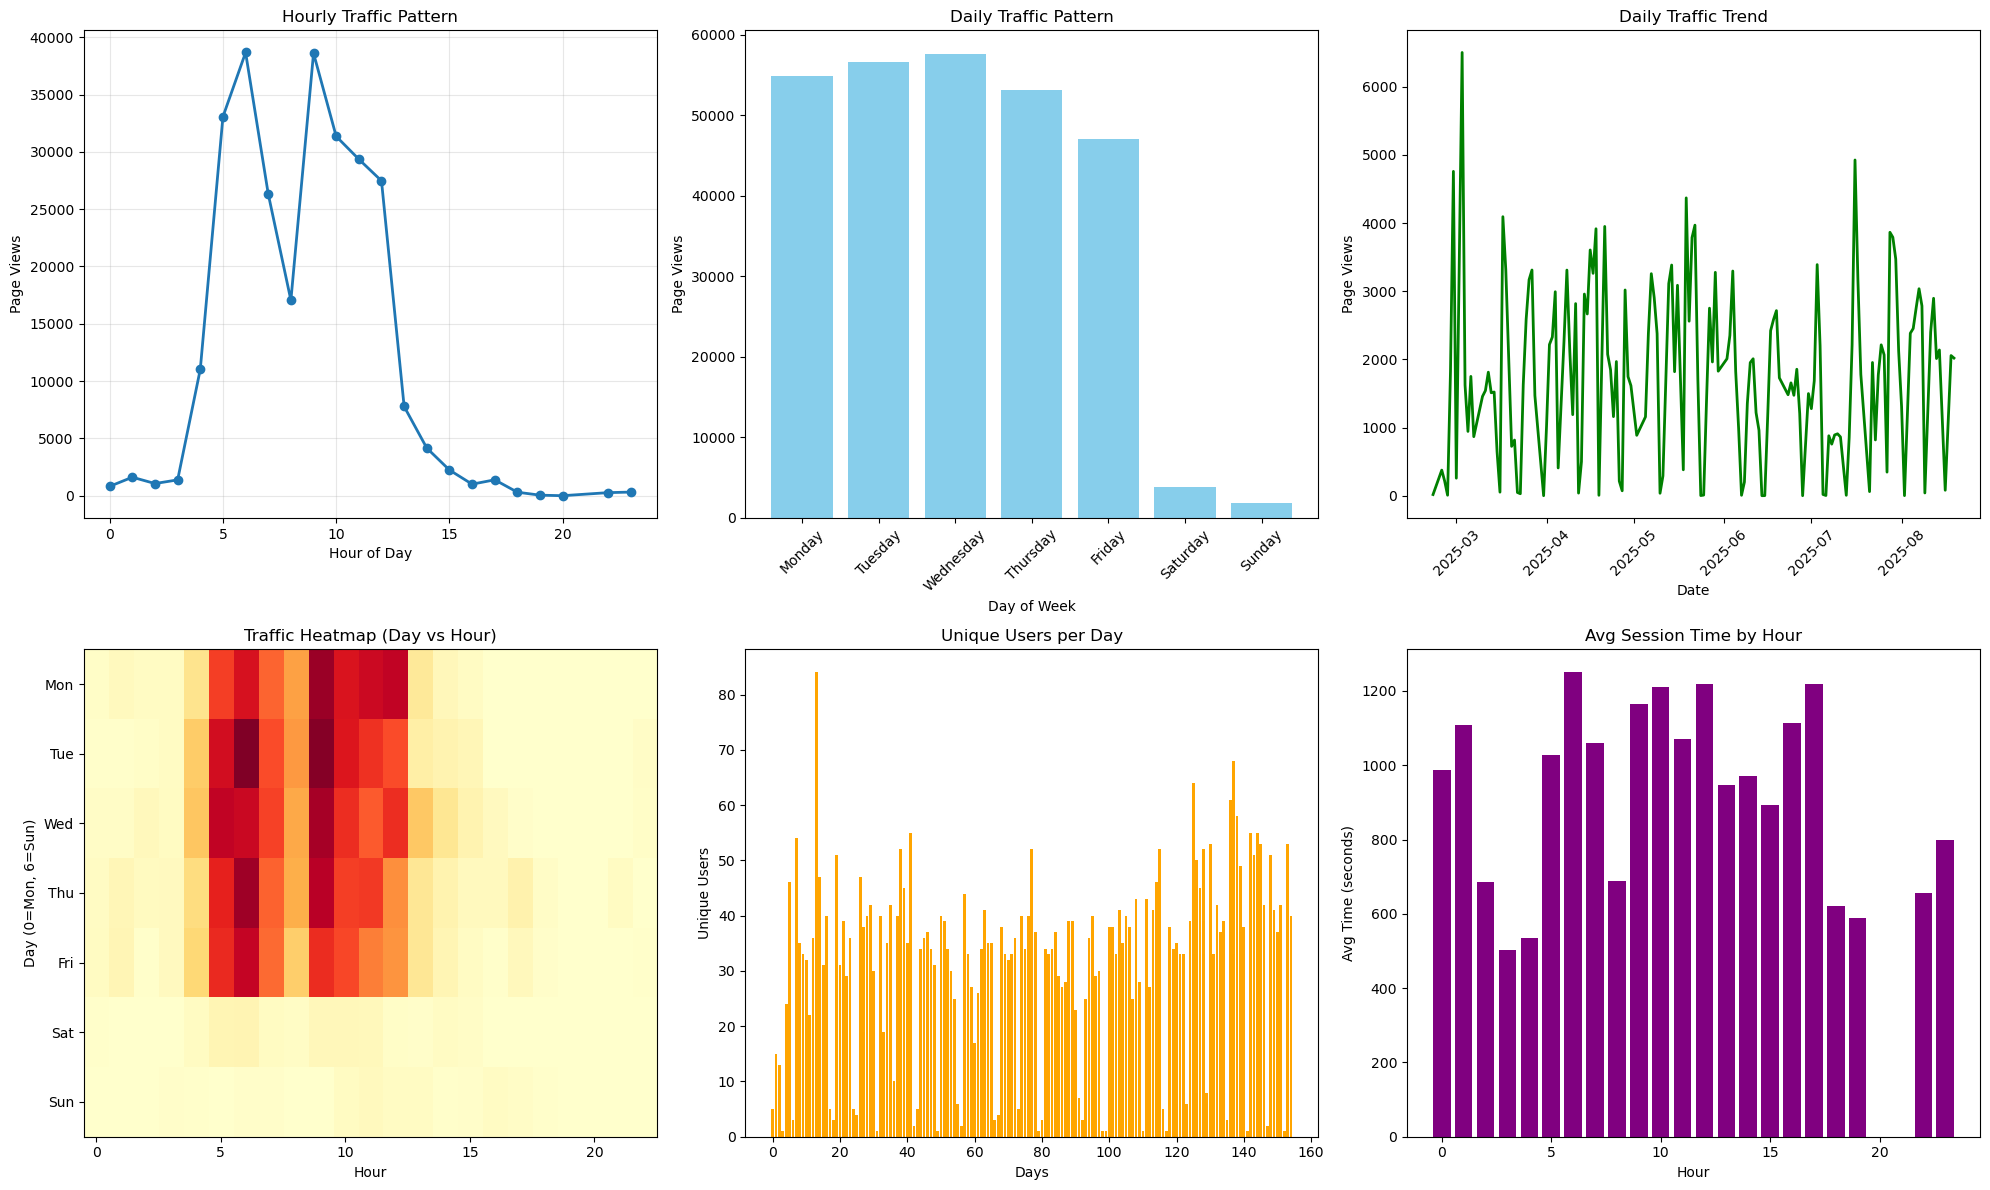

Time-Based Analytics Insights:
Peak Traffic Hour: 6:00 (38672 views)
Peak Traffic Day: Wednesday (57693 views)
Total Unique Users: 1302
Date Range: 2025-02-21 to 2025-08-19


In [20]:
# Time-Based Analytics Dashboard
def create_time_analytics_dashboard(df):
    # Convert server_time to datetime
    df['datetime'] = pd.to_datetime(df['server_time'])
    df['hour'] = df['datetime'].dt.hour
    df['day'] = df['datetime'].dt.day_name()
    df['date'] = df['datetime'].dt.date
    
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    
    # 1. Hourly Traffic Pattern
    hourly_traffic = df.groupby('hour').size()
    axes[0, 0].plot(hourly_traffic.index, hourly_traffic.values, marker='o', linewidth=2)
    axes[0, 0].set_title('Hourly Traffic Pattern')
    axes[0, 0].set_xlabel('Hour of Day')
    axes[0, 0].set_ylabel('Page Views')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Daily Traffic Pattern
    daily_traffic = df.groupby('day').size().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
    axes[0, 1].bar(daily_traffic.index, daily_traffic.values, color='skyblue')
    axes[0, 1].set_title('Daily Traffic Pattern')
    axes[0, 1].set_xlabel('Day of Week')
    axes[0, 1].set_ylabel('Page Views')
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    # 3. Daily Trend
    daily_trend = df.groupby('date').size()
    axes[0, 2].plot(daily_trend.index, daily_trend.values, linewidth=2, color='green')
    axes[0, 2].set_title('Daily Traffic Trend')
    axes[0, 2].set_xlabel('Date')
    axes[0, 2].set_ylabel('Page Views')
    axes[0, 2].tick_params(axis='x', rotation=45)
    
    # 4. Peak Hours Heatmap
    df['day_num'] = df['datetime'].dt.dayofweek
    heatmap_data = df.groupby(['day_num', 'hour']).size().unstack(fill_value=0)
    im = axes[1, 0].imshow(heatmap_data.values, cmap='YlOrRd', aspect='auto')
    axes[1, 0].set_title('Traffic Heatmap (Day vs Hour)')
    axes[1, 0].set_xlabel('Hour')
    axes[1, 0].set_ylabel('Day (0=Mon, 6=Sun)')
    axes[1, 0].set_yticks(range(7))
    axes[1, 0].set_yticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
    
    # 5. Unique Users per Day
    daily_users = df.groupby('date')['idvisitor_y'].nunique()
    axes[1, 1].bar(range(len(daily_users)), daily_users.values, color='orange')
    axes[1, 1].set_title('Unique Users per Day')
    axes[1, 1].set_xlabel('Days')
    axes[1, 1].set_ylabel('Unique Users')
    
    # 6. Average Session Length by Hour
    hourly_sessions = df.groupby(['hour', 'idvisit'])['time_spent_ref_action'].sum().groupby('hour').mean()
    axes[1, 2].bar(hourly_sessions.index, hourly_sessions.values, color='purple')
    axes[1, 2].set_title('Avg Session Time by Hour')
    axes[1, 2].set_xlabel('Hour')
    axes[1, 2].set_ylabel('Avg Time (seconds)')
    
    plt.tight_layout()
    plt.show()
    
    # Print insights
    print("Time-Based Analytics Insights:")
    print("=" * 50)
    peak_hour = hourly_traffic.idxmax()
    peak_day = daily_traffic.idxmax()
    print(f"Peak Traffic Hour: {peak_hour}:00 ({hourly_traffic[peak_hour]} views)")
    print(f"Peak Traffic Day: {peak_day} ({daily_traffic[peak_day]} views)")
    print(f"Total Unique Users: {df['idvisitor_y'].nunique()}")
    print(f"Date Range: {df['date'].min()} to {df['date'].max()}")

create_time_analytics_dashboard(final_dataset)

/tmp/ipykernel_3650848/431326832.py:34: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  page_transitions = df.groupby(['idvisit']).apply(


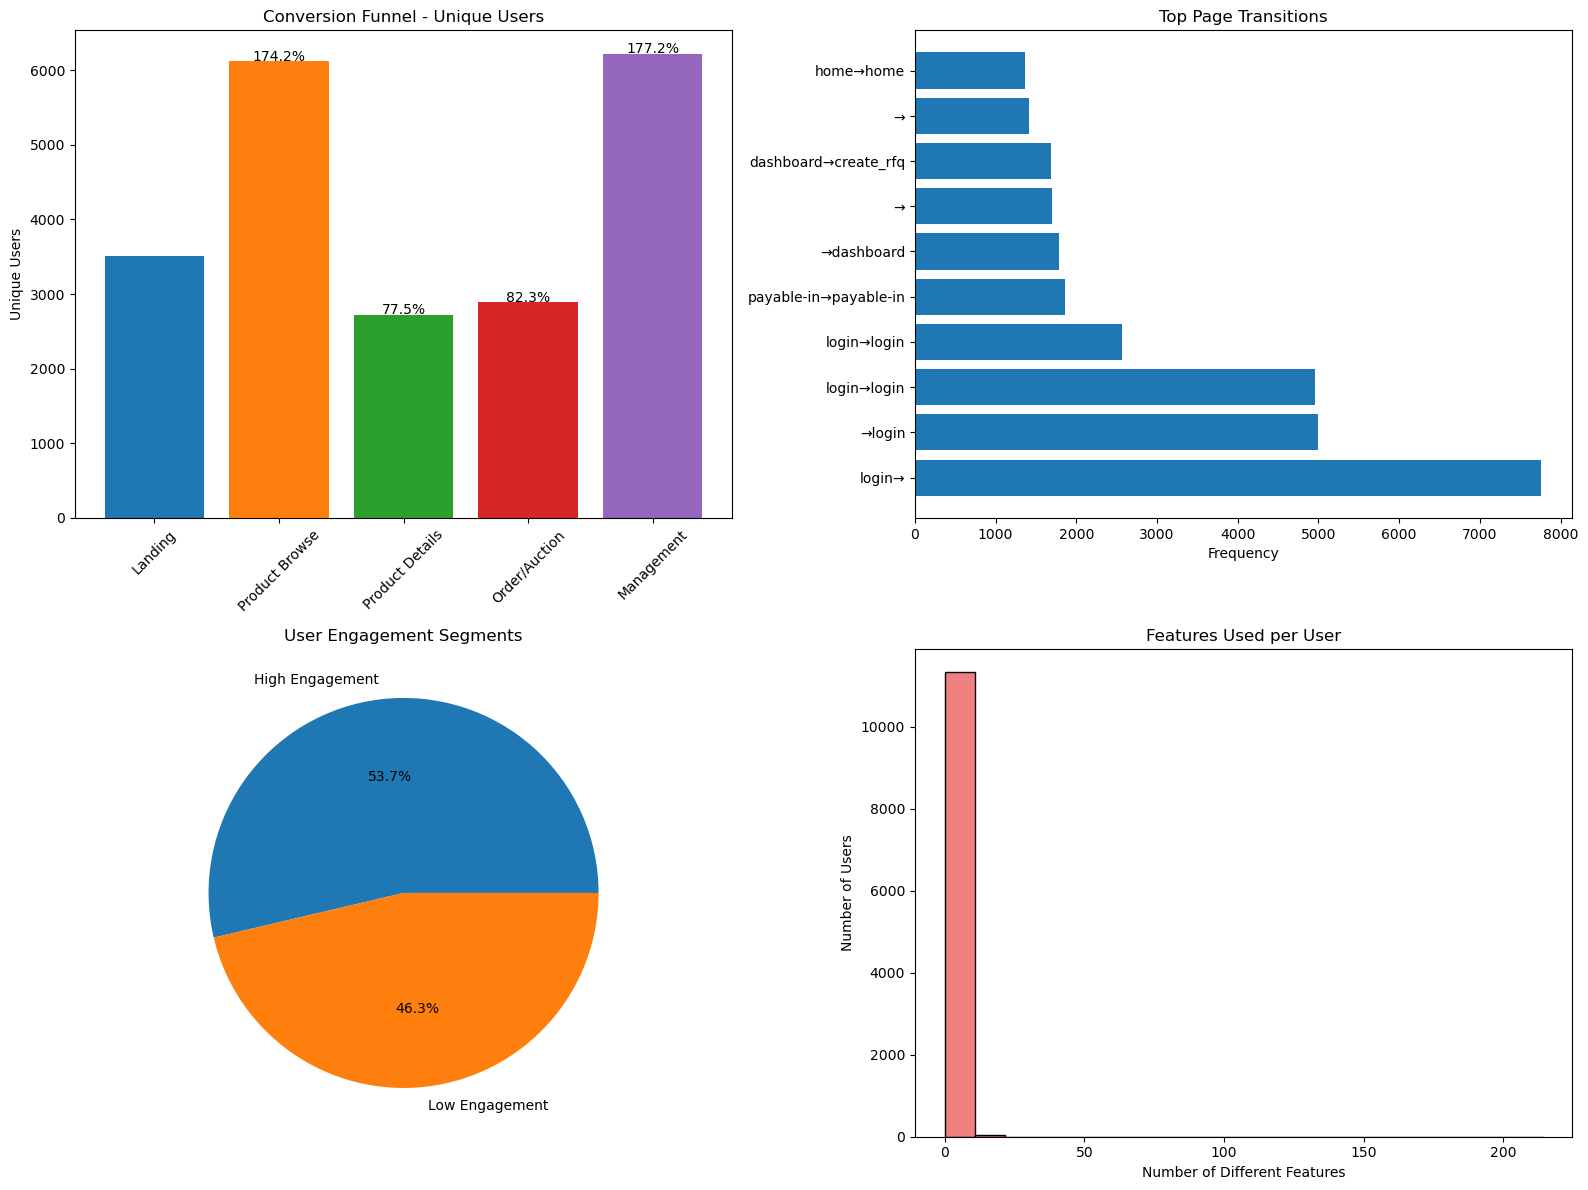

Conversion & Flow Analysis Insights:
Funnel Conversion Rates:
  Landing: 3511 users (100.0%)
  Product Browse: 6117 users (174.2%)
  Product Details: 2721 users (77.5%)
  Order/Auction: 2889 users (82.3%)
  Management: 6223 users (177.2%)

User Engagement Distribution:
  High Engagement: 6101 users (53.7%)
  Low Engagement: 5265 users (46.3%)


In [40]:
# Conversion Funnel and User Flow Analysis
def create_funnel_analysis(df):
    # Define key pages in the conversion funnel
    funnel_pages = {
        'Landing': df['full_url'].str.contains('auth|login', case=False, na=False),
        'Product Browse': df['full_url'].str.contains('product|e-commerce|rfq', case=False, na=False),
        'Product Details': df['full_url'].str.contains('product-details|prf', case=False, na=False),
        'Order/Auction': df['full_url'].str.contains('order|auction|deal-room', case=False, na=False),
        'Management': df['full_url'].str.contains('management|dashboard', case=False, na=False)
    }
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Funnel Conversion
    funnel_counts = {}
    for stage, condition in funnel_pages.items():
        funnel_counts[stage] = df[condition]['idvisitor_y'].nunique()
    
    stages = list(funnel_counts.keys())
    counts = list(funnel_counts.values())
    
    axes[0, 0].bar(stages, counts, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
    axes[0, 0].set_title('Conversion Funnel - Unique Users')
    axes[0, 0].set_ylabel('Unique Users')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # Add conversion rates
    for i, (stage, count) in enumerate(zip(stages, counts)):
        if i > 0:
            conversion_rate = (count / counts[0]) * 100
            axes[0, 0].text(i, count + 5, f'{conversion_rate:.1f}%', ha='center')
    
    # 2. Page Flow Analysis
    page_transitions = df.groupby(['idvisit']).apply(
        lambda x: list(zip(x['full_url'].iloc[:-1], x['full_url'].iloc[1:]))
    ).explode().dropna()
    
    if len(page_transitions) > 0:
        transition_counts = page_transitions.value_counts().head(10)
        transition_labels = [f"{t[0].split('/')[-1][:10]}→{t[1].split('/')[-1][:10]}" for t in transition_counts.index]
        
        axes[0, 1].barh(range(len(transition_counts)), transition_counts.values)
        axes[0, 1].set_yticks(range(len(transition_counts)))
        axes[0, 1].set_yticklabels(transition_labels)
        axes[0, 1].set_title('Top Page Transitions')
        axes[0, 1].set_xlabel('Frequency')
    
    # 3. User Segment Analysis
    user_behavior = df.groupby('idvisitor_y').agg({
        'full_url': 'count',
        'idvisit': 'nunique',
        'time_spent_ref_action': 'sum'
    }).rename(columns={'full_url': 'page_views', 'idvisit': 'sessions', 'time_spent_ref_action': 'total_time'})
    
    # Categorize users
    user_behavior['user_type'] = 'Low Engagement'
    user_behavior.loc[(user_behavior['page_views'] > 5) & (user_behavior['sessions'] > 1), 'user_type'] = 'Medium Engagement'
    user_behavior.loc[(user_behavior['page_views'] > 20) | (user_behavior['total_time'] > 300), 'user_type'] = 'High Engagement'
    
    user_segments = user_behavior['user_type'].value_counts()
    axes[1, 0].pie(user_segments.values, labels=user_segments.index, autopct='%1.1f%%')
    axes[1, 0].set_title('User Engagement Segments')
    
    # 4. Feature Usage Matrix
    features_used = df.groupby('idvisitor_y')['full_url'].apply(
        lambda x: [url.split('/')[3] if len(url.split('/')) > 3 else 'root' for url in x if pd.notna(url)]
    ).apply(lambda x: len(set(x)))
    
    axes[1, 1].hist(features_used, bins=20, edgecolor='black', color='lightcoral')
    axes[1, 1].set_title('Features Used per User')
    axes[1, 1].set_xlabel('Number of Different Features')
    axes[1, 1].set_ylabel('Number of Users')
    
    plt.tight_layout()
    plt.show()
    
    # Print insights
    print("Conversion & Flow Analysis Insights:")
    print("=" * 50)
    print("Funnel Conversion Rates:")
    for i, (stage, count) in enumerate(zip(stages, counts)):
        if i == 0:
            print(f"  {stage}: {count} users (100.0%)")
        else:
            rate = (count / counts[0]) * 100
            print(f"  {stage}: {count} users ({rate:.1f}%)")
    
    print(f"\nUser Engagement Distribution:")
    for segment, count in user_segments.items():
        print(f"  {segment}: {count} users ({count/len(user_behavior)*100:.1f}%)")
    
    return user_behavior

user_segments_data = create_funnel_analysis(final_dataset)

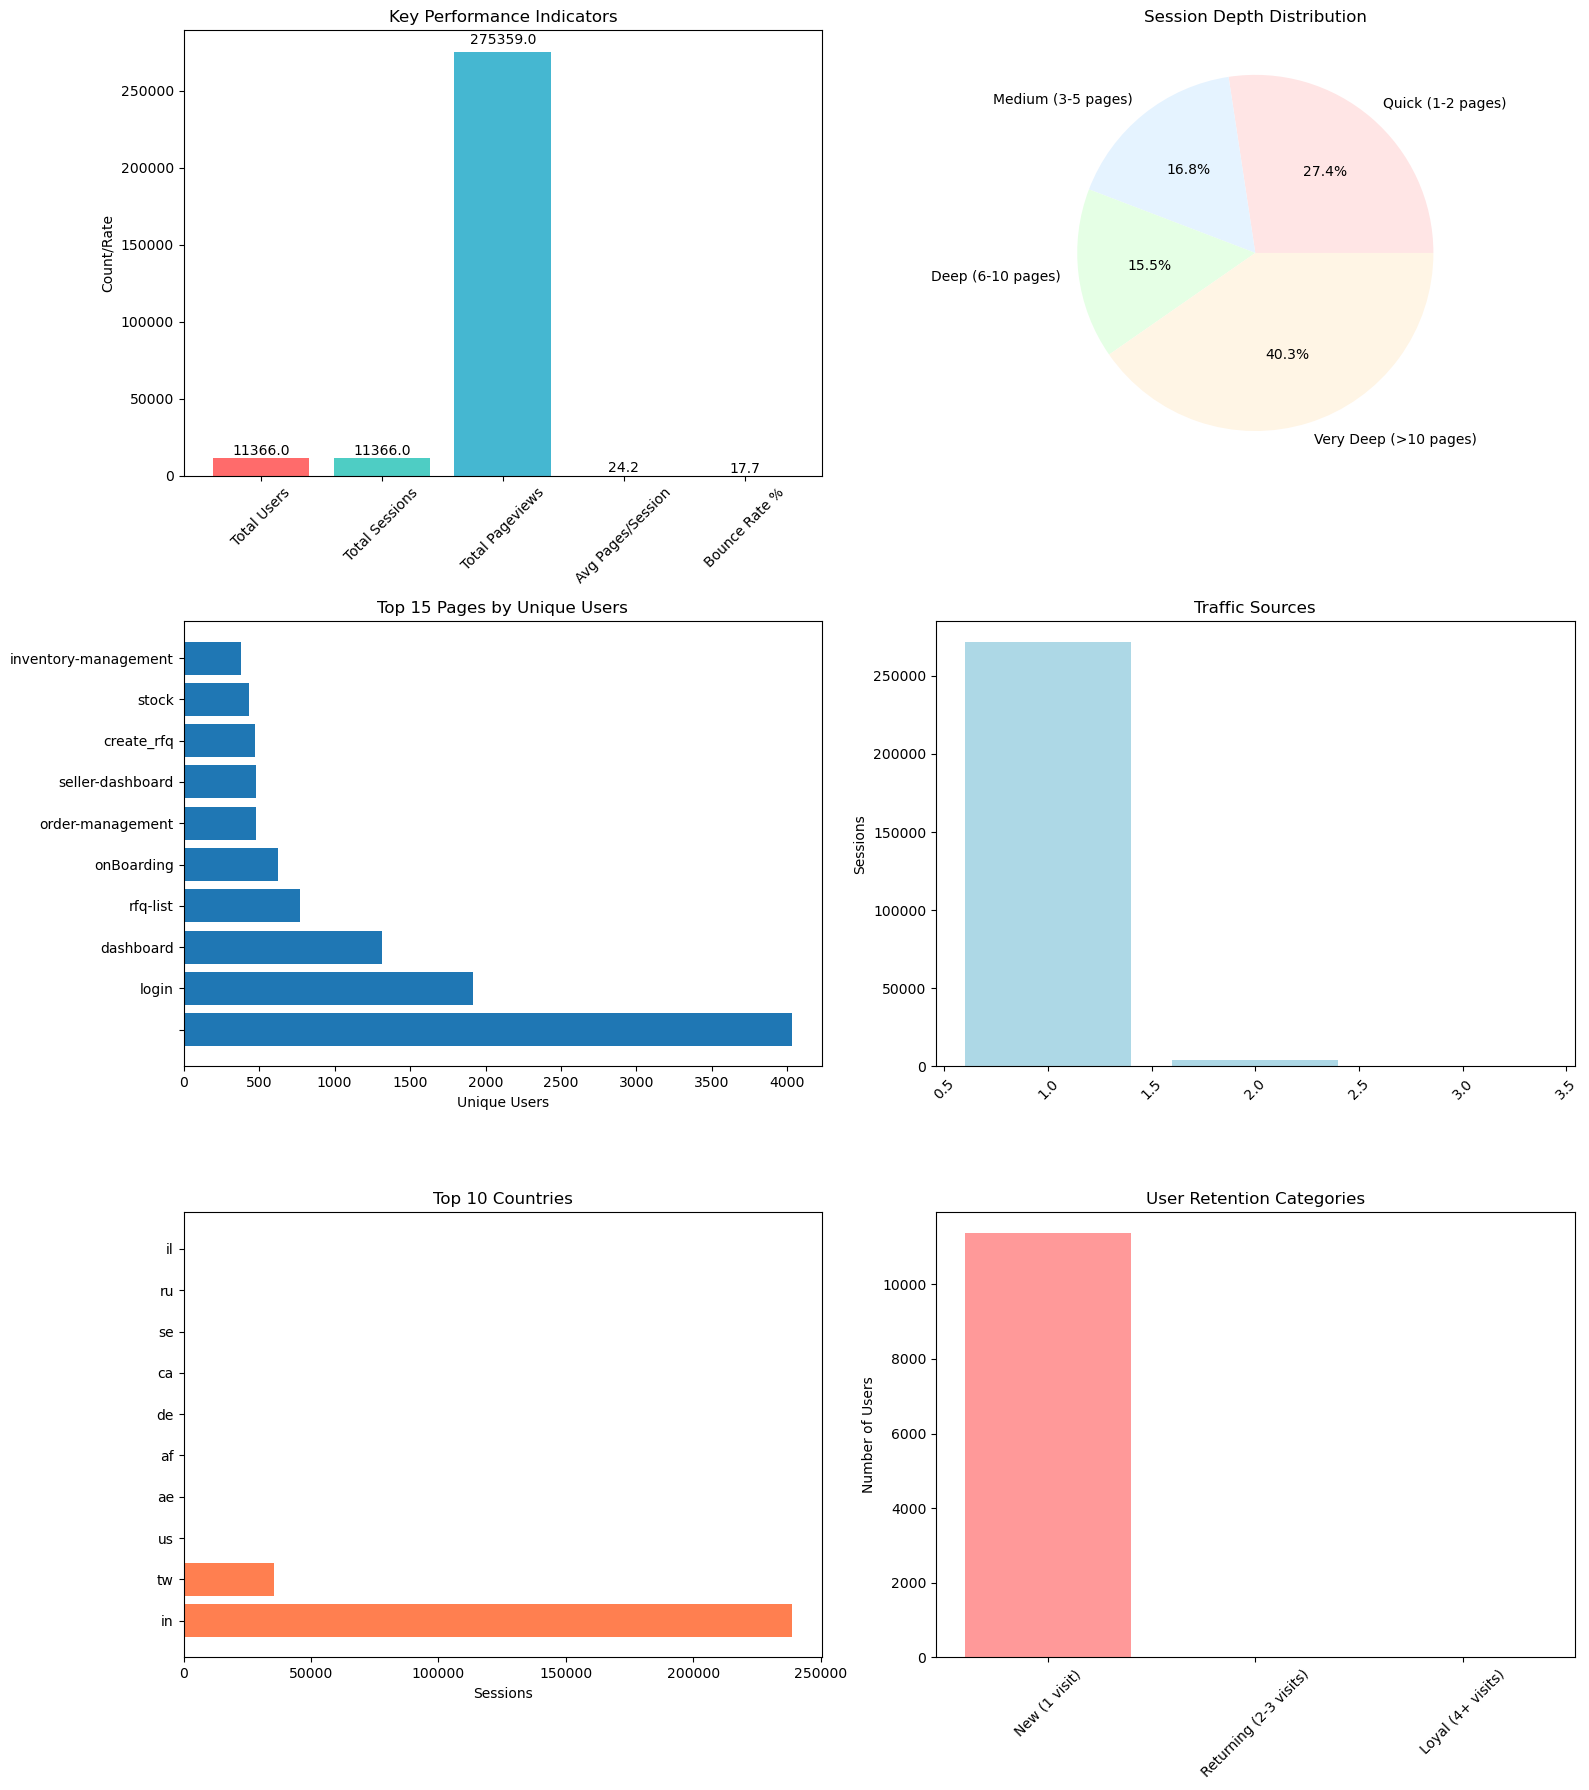

Performance & KPI Dashboard Insights:
 OVERVIEW METRICS:
   Total Unique Users: 11,366
   Total Sessions: 11,366
   Total Pageviews: 275,359
   Average Pages per Session: 24.23
   Bounce Rate: 17.7%

 ENGAGEMENT QUALITY:
   Quick (1-2 pages): 3112 sessions (27.4%)
   Medium (3-5 pages): 1907 sessions (16.8%)
   Deep (6-10 pages): 1758 sessions (15.5%)
   Very Deep (>10 pages): 4581 sessions (40.3%)

 USER RETENTION:
   New (1 visit): 11366 users (100.0%)
   Returning (2-3 visits): 0 users (0.0%)
   Loyal (4+ visits): 0 users (0.0%)

 TOP PERFORMING CONTENT:
   1. Homepage: 4028.0 users, 88.8s avg time
   2. login: 1917.0 users, 42.4s avg time
   3. dashboard: 1314.0 users, 58.7s avg time
   4. Homepage: 786.0 users, 93.5s avg time
   5. dashboard: 783.0 users, 56.9s avg time


In [41]:
# Performance Metrics and KPI Dashboard
def create_kpi_dashboard(df, user_segments):
    fig, axes = plt.subplots(3, 2, figsize=(16, 18))
    
    # 1. Key Performance Indicators
    total_users = df['idvisitor_y'].nunique()
    total_sessions = df['idvisit'].nunique()
    total_pageviews = len(df)
    avg_session_pages = total_pageviews / total_sessions
    bounce_rate = len(user_segments[user_segments['page_views'] == 1]) / len(user_segments) * 100
    
    kpis = ['Total Users', 'Total Sessions', 'Total Pageviews', 'Avg Pages/Session', 'Bounce Rate %']
    kpi_values = [total_users, total_sessions, total_pageviews, avg_session_pages, bounce_rate]
    
    bars = axes[0, 0].bar(kpis, kpi_values, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FECA57'])
    axes[0, 0].set_title('Key Performance Indicators')
    axes[0, 0].set_ylabel('Count/Rate')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar, value in zip(bars, kpi_values):
        height = bar.get_height()
        axes[0, 0].text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                       f'{value:.1f}', ha='center', va='bottom')
    
    # 2. Session Quality Metrics
    session_quality = df.groupby('idvisit').agg({
        'pageview_position': 'max',
        'time_spent_ref_action': 'sum',
        'full_url': 'nunique'
    }).rename(columns={'pageview_position': 'pages', 'time_spent_ref_action': 'duration', 'full_url': 'unique_pages'})
    
    quality_bins = ['Quick (1-2 pages)', 'Medium (3-5 pages)', 'Deep (6-10 pages)', 'Very Deep (>10 pages)']
    quality_counts = [
        len(session_quality[session_quality['pages'] <= 2]),
        len(session_quality[(session_quality['pages'] > 2) & (session_quality['pages'] <= 5)]),
        len(session_quality[(session_quality['pages'] > 5) & (session_quality['pages'] <= 10)]),
        len(session_quality[session_quality['pages'] > 10])
    ]
    
    axes[0, 1].pie(quality_counts, labels=quality_bins, autopct='%1.1f%%', 
                   colors=['#FFE5E5', '#E5F3FF', '#E5FFE5', '#FFF5E5'])
    axes[0, 1].set_title('Session Depth Distribution')
    
    # 3. Content Performance
    content_performance = df.groupby('full_url').agg({
        'idvisitor_y': 'nunique',
        'idvisit': 'nunique',
        'time_spent_ref_action': 'mean'
    }).rename(columns={'idvisitor_y': 'unique_users', 'idvisit': 'sessions', 'time_spent_ref_action': 'avg_time'})
    
    top_content = content_performance.nlargest(15, 'unique_users')
    page_names = [url.split('/')[-1][:20] + '...' if len(url.split('/')[-1]) > 20 else url.split('/')[-1] for url in top_content.index]
    
    axes[1, 0].barh(page_names, top_content['unique_users'])
    axes[1, 0].set_title('Top 15 Pages by Unique Users')
    axes[1, 0].set_xlabel('Unique Users')
    
    # 4. Traffic Sources Analysis (based on referer data if available)
    if 'referer_type' in df.columns:
        traffic_sources = df['referer_type'].value_counts().head(8)
        axes[1, 1].bar(traffic_sources.index, traffic_sources.values, color='lightblue')
        axes[1, 1].set_title('Traffic Sources')
        axes[1, 1].set_ylabel('Sessions')
        axes[1, 1].tick_params(axis='x', rotation=45)
    else:
        # Alternative: Browser analysis
        if 'config_browser_name' in df.columns:
            browsers = df['config_browser_name'].value_counts().head(8)
            axes[1, 1].bar(browsers.index, browsers.values, color='lightgreen')
            axes[1, 1].set_title('Top Browsers')
            axes[1, 1].set_ylabel('Sessions')
            axes[1, 1].tick_params(axis='x', rotation=45)
    
    # 5. Geographic Analysis (if location data available)
    if 'location_country' in df.columns:
        countries = df['location_country'].value_counts().head(10)
        axes[2, 0].barh(countries.index, countries.values, color='coral')
        axes[2, 0].set_title('Top 10 Countries')
        axes[2, 0].set_xlabel('Sessions')
    else:
        # Alternative: Device analysis
        if 'config_device_type' in df.columns:
            devices = df['config_device_type'].value_counts()
            axes[2, 0].pie(devices.values, labels=devices.index, autopct='%1.1f%%')
            axes[2, 0].set_title('Device Types')
    
    # 6. User Retention Analysis
    user_visit_counts = df.groupby('idvisitor_y')['idvisit'].nunique()
    retention_categories = ['New (1 visit)', 'Returning (2-3 visits)', 'Loyal (4+ visits)']
    retention_counts = [
        len(user_visit_counts[user_visit_counts == 1]),
        len(user_visit_counts[(user_visit_counts >= 2) & (user_visit_counts <= 3)]),
        len(user_visit_counts[user_visit_counts >= 4])
    ]
    
    axes[2, 1].bar(retention_categories, retention_counts, color=['#FF9999', '#66B2FF', '#99FF99'])
    axes[2, 1].set_title('User Retention Categories')
    axes[2, 1].set_ylabel('Number of Users')
    axes[2, 1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Print comprehensive insights
    print("Performance & KPI Dashboard Insights:")
    print(f" OVERVIEW METRICS:")
    print(f"   Total Unique Users: {total_users:,}")
    print(f"   Total Sessions: {total_sessions:,}")
    print(f"   Total Pageviews: {total_pageviews:,}")
    print(f"   Average Pages per Session: {avg_session_pages:.2f}")
    print(f"   Bounce Rate: {bounce_rate:.1f}%")
    
    print(f"\n ENGAGEMENT QUALITY:")
    for category, count in zip(quality_bins, quality_counts):
        percentage = (count / total_sessions) * 100
        print(f"   {category}: {count} sessions ({percentage:.1f}%)")
    
    print(f"\n USER RETENTION:")
    for category, count in zip(retention_categories, retention_counts):
        percentage = (count / total_users) * 100
        print(f"   {category}: {count} users ({percentage:.1f}%)")
    
    print(f"\n TOP PERFORMING CONTENT:")
    for i, (url, data) in enumerate(top_content.head(5).iterrows(), 1):
        page_name = url.split('/')[-1] if url.split('/')[-1] else 'Homepage'
        print(f"   {i}. {page_name}: {data['unique_users']} users, {data['avg_time']:.1f}s avg time")

create_kpi_dashboard(final_dataset, user_segments_data)

 ADVANCED ANALYTICS SEARCH & FILTER TOOL

 SAMPLE SEARCH QUERIES:
 'auth': 3511 users, 28994 views
 'product': 4427 users, 45122 views
 'dashboard': 3865 users, 18516 views
 'rfq': 3311 users, 52559 views
 'auction': 1140 users, 13923 views

 DOMAIN PERFORMANCE COMPARISON:
 'dashboard': 3865 users, 18516 views
 'rfq': 3311 users, 52559 views
 'auction': 1140 users, 13923 views

 DOMAIN PERFORMANCE COMPARISON:
 127.0.0.1:
   Users: 1.0, Sessions: 1.0, Views: 4.0
 192.168.9.133:
   Users: 103.0, Sessions: 103.0, Views: 932.0
 192.168.9.146:
   Users: 126.0, Sessions: 126.0, Views: 585.0
 192.168.9.148:
   Users: 3.0, Sessions: 3.0, Views: 15.0
 192.168.9.170:
   Users: 8.0, Sessions: 8.0, Views: 138.0

 FEATURE USAGE ANALYSIS:
 127.0.0.1:
   Users: 1.0, Sessions: 1.0, Views: 4.0
 192.168.9.133:
   Users: 103.0, Sessions: 103.0, Views: 932.0
 192.168.9.146:
   Users: 126.0, Sessions: 126.0, Views: 585.0
 192.168.9.148:
   Users: 3.0, Sessions: 3.0, Views: 15.0
 192.168.9.170:
   Users: 8.

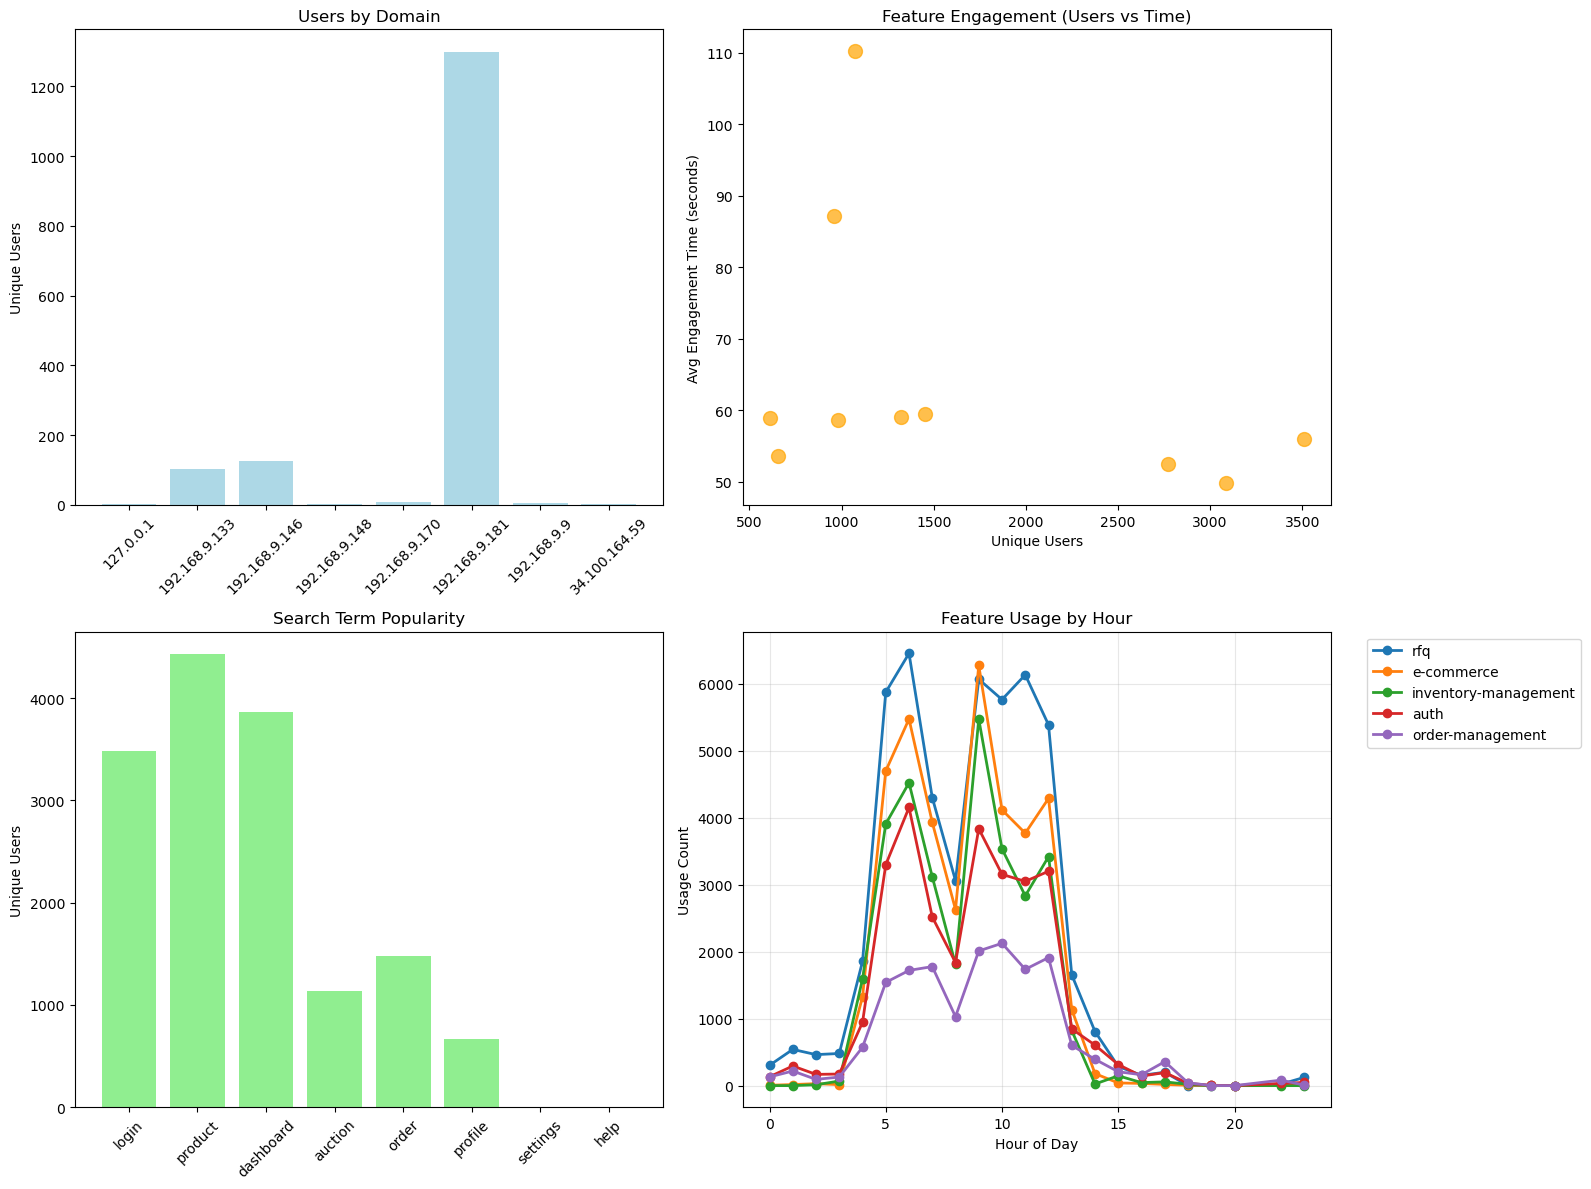


  USAGE EXAMPLES:
# Filter data for specific domain:
# filtered_data = analytics_tools['filter_by_domain']('devpy.vipani.ai')

# Search for specific metrics:
# results = analytics_tools['search_analytics']('login', 'users')

# Get user profile:
# profile = analytics_tools['get_user_profile']('specific_visitor_id')


In [43]:
# Advanced Search and Filter Dashboard
def create_search_filter_dashboard(df):
    print(" ADVANCED ANALYTICS SEARCH & FILTER TOOL")
    
    # Create interactive filter functions
    def filter_by_date_range(start_date=None, end_date=None):
        df_filtered = df.copy()
        df_filtered['date'] = pd.to_datetime(df_filtered['server_time']).dt.date
        
        if start_date:
            df_filtered = df_filtered[df_filtered['date'] >= pd.to_datetime(start_date).date()]
        if end_date:
            df_filtered = df_filtered[df_filtered['date'] <= pd.to_datetime(end_date).date()]
            
        return df_filtered
    
    def filter_by_domain(domain_name):
        return df[df['full_url'].str.contains(domain_name, case=False, na=False)]
    
    def filter_by_feature(feature_name):
        return df[df['full_url'].str.contains(feature_name, case=False, na=False)]
    
    def get_user_profile(visitor_id):
        user_data = df[df['idvisitor_y'] == visitor_id]
        if len(user_data) == 0:
            return "User not found"
        
        profile = {
            'total_sessions': user_data['idvisit'].nunique(),
            'total_pageviews': len(user_data),
            'unique_pages': user_data['full_url'].nunique(),
            'total_time_spent': user_data['time_spent_ref_action'].sum(),
            'first_visit': user_data['server_time'].min(),
            'last_visit': user_data['server_time'].max(),
            'favorite_features': user_data['full_url'].str.extract(r'(?:https?://[^/]+/)([^/]+)')[0].value_counts().head(3).to_dict(),
            'journey_path': user_data.groupby('idvisit')['full_url'].apply(lambda x: ' → '.join(x.astype(str))).tolist()
        }
        return profile
    
    # Search functionality
    def search_analytics(keyword=None, metric_type='all'):
        results = {}
        
        if keyword:
            keyword_data = df[df['full_url'].str.contains(keyword, case=False, na=False)]
            
            if metric_type in ['all', 'users']:
                results['unique_users'] = keyword_data['idvisitor_y'].nunique()
            if metric_type in ['all', 'sessions']:
                results['sessions'] = keyword_data['idvisit'].nunique()
            if metric_type in ['all', 'pageviews']:
                results['pageviews'] = len(keyword_data)
            if metric_type in ['all', 'time']:
                results['avg_time_spent'] = keyword_data['time_spent_ref_action'].mean()
                
        return results
    
    # Demonstrate search capabilities
    print("\n SAMPLE SEARCH QUERIES:")
    
    # Search examples
    search_terms = ['auth', 'product', 'dashboard', 'rfq', 'auction']
    for term in search_terms:
        results = search_analytics(term)
        if results:
            print(f" '{term}': {results.get('unique_users', 0)} users, {results.get('pageviews', 0)} views")
    
    # Domain analysis
    print(f"\n DOMAIN PERFORMANCE COMPARISON:")
    
    # Extract main domains
    df['domain'] = df['full_url'].str.extract(r'https?://([^/]+)')[0]
    domain_stats = df.groupby('domain').agg({
        'idvisitor_y': 'nunique',
        'idvisit': 'nunique',
        'full_url': 'count',
        'time_spent_ref_action': 'mean'
    }).rename(columns={
        'idvisitor_y': 'unique_users',
        'idvisit': 'sessions', 
        'full_url': 'pageviews',
        'time_spent_ref_action': 'avg_time'
    }).round(2)
    
    for domain, stats in domain_stats.head(5).iterrows():
        print(f" {domain}:")
        print(f"   Users: {stats['unique_users']}, Sessions: {stats['sessions']}, Views: {stats['pageviews']}")
    
    # Feature popularity analysis
    print(f"\n FEATURE USAGE ANALYSIS:")
    
    # Extract features (first path segment)
    df['feature'] = df['full_url'].str.extract(r'(?:https?://[^/]+/)([^/]+)')[0]
    feature_stats = df.groupby('feature').agg({
        'idvisitor_y': 'nunique',
        'time_spent_ref_action': 'mean'
    }).rename(columns={
        'idvisitor_y': 'unique_users',
        'time_spent_ref_action': 'avg_engagement_time'
    }).sort_values('unique_users', ascending=False).head(10)
    
    for feature, stats in feature_stats.iterrows():
        if pd.notna(feature):
            engagement_score = stats['unique_users'] * stats['avg_engagement_time'] if pd.notna(stats['avg_engagement_time']) else 0
            print(f" {feature}: {stats['unique_users']} users, {stats['avg_engagement_time']:.1f}s avg time")
    
    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Domain comparison
    domain_users = domain_stats['unique_users'].head(8)
    axes[0, 0].bar(range(len(domain_users)), domain_users.values, color='lightblue')
    axes[0, 0].set_title('Users by Domain')
    axes[0, 0].set_xticks(range(len(domain_users)))
    axes[0, 0].set_xticklabels([d[:15] + '...' if len(d) > 15 else d for d in domain_users.index], rotation=45)
    axes[0, 0].set_ylabel('Unique Users')
    
    # 2. Feature engagement
    feature_engagement = feature_stats.head(10)
    axes[0, 1].scatter(feature_engagement['unique_users'], feature_engagement['avg_engagement_time'], 
                      s=100, alpha=0.7, color='orange')
    axes[0, 1].set_title('Feature Engagement (Users vs Time)')
    axes[0, 1].set_xlabel('Unique Users')
    axes[0, 1].set_ylabel('Avg Engagement Time (seconds)')
    
    # 3. Search term popularity
    search_results = {}
    for term in ['login', 'product', 'dashboard', 'auction', 'order', 'profile', 'settings', 'help']:
        results = search_analytics(term)
        if results and 'unique_users' in results:
            search_results[term] = results['unique_users']
    
    if search_results:
        axes[1, 0].bar(search_results.keys(), search_results.values(), color='lightgreen')
        axes[1, 0].set_title('Search Term Popularity')
        axes[1, 0].set_ylabel('Unique Users')
        axes[1, 0].tick_params(axis='x', rotation=45)
    
    # 4. Time-based filter example
    df['hour'] = pd.to_datetime(df['server_time']).dt.hour
    hourly_features = df.groupby(['hour', 'feature']).size().unstack(fill_value=0)
    
    # Select top 5 features for visibility
    top_features = df['feature'].value_counts().head(5).index
    if len(top_features) > 0:
        for i, feature in enumerate(top_features):
            if feature in hourly_features.columns:
                axes[1, 1].plot(hourly_features.index, hourly_features[feature], 
                               label=feature, marker='o', linewidth=2)
        
        axes[1, 1].set_title('Feature Usage by Hour')
        axes[1, 1].set_xlabel('Hour of Day')
        axes[1, 1].set_ylabel('Usage Count')
        axes[1, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'filter_by_date': filter_by_date_range,
        'filter_by_domain': filter_by_domain,
        'filter_by_feature': filter_by_feature,
        'search_analytics': search_analytics,
        'get_user_profile': get_user_profile,
        'domain_stats': domain_stats,
        'feature_stats': feature_stats
    }

# Create the search and filter dashboard
analytics_tools = create_search_filter_dashboard(final_dataset)

# Example usage demonstrations
print(f"\n  USAGE EXAMPLES:")
print("# Filter data for specific domain:")
print("# filtered_data = analytics_tools['filter_by_domain']('devpy.vipani.ai')")
print("\n# Search for specific metrics:")
print("# results = analytics_tools['search_analytics']('login', 'users')")
print("\n# Get user profile:")
print("# profile = analytics_tools['get_user_profile']('specific_visitor_id')")

# Superset SQL Lab - Complete Analytics Table

This section provides the SQL query to create a comprehensive analytics table in Superset SQL Lab with all required columns for dashboard creation.

In [44]:
# Complete SQL Query for Superset SQL Lab
# Copy this query to Superset SQL Lab to create your analytics dataset

superset_sql_query = """
SELECT 
    -- Primary Keys and Identifiers
    lva.idvisit,
    lv.idvisitor,
    lva.idaction_url,
    lva.idaction_name,
    
    -- URL and Page Information
    CASE 
        WHEN la.url_prefix = 0 THEN 'http://' || la.name
        WHEN la.url_prefix = 1 THEN 'http://www.' || la.name  
        WHEN la.url_prefix = 2 THEN 'https://' || la.name
        WHEN la.url_prefix = 3 THEN 'https://www.' || la.name
        ELSE la.name
    END AS full_url,
    
    -- Feature Extraction (First path segment after domain)
    CASE 
        WHEN la.name IS NULL THEN 'Unknown'
        ELSE COALESCE(
            SPLIT_PART(
                REGEXP_REPLACE(
                    CASE 
                        WHEN la.url_prefix = 0 THEN 'http://' || la.name
                        WHEN la.url_prefix = 1 THEN 'http://www.' || la.name  
                        WHEN la.url_prefix = 2 THEN 'https://' || la.name
                        WHEN la.url_prefix = 3 THEN 'https://www.' || la.name
                        ELSE la.name
                    END, 
                    '^https?://[^/]*/', ''
                ), 
                '/', 1
            ), 
            'homepage'
        )
    END AS feature,
    
    -- Domain Extraction
    CASE 
        WHEN la.name IS NULL THEN 'Unknown'
        ELSE REGEXP_REPLACE(
            CASE 
                WHEN la.url_prefix = 0 THEN 'http://' || la.name
                WHEN la.url_prefix = 1 THEN 'http://www.' || la.name  
                WHEN la.url_prefix = 2 THEN 'https://' || la.name
                WHEN la.url_prefix = 3 THEN 'https://www.' || la.name
                ELSE la.name
            END, 
            '^https?://([^/]+).*', '\\1'
        )
    END AS domain,
    
    -- Time and Date Dimensions
    lva.server_time,
    EXTRACT(HOUR FROM lva.server_time) AS hour_of_day,
    EXTRACT(DOW FROM lva.server_time) AS day_of_week,
    CASE EXTRACT(DOW FROM lva.server_time)
        WHEN 0 THEN 'Sunday'
        WHEN 1 THEN 'Monday' 
        WHEN 2 THEN 'Tuesday'
        WHEN 3 THEN 'Wednesday'
        WHEN 4 THEN 'Thursday'
        WHEN 5 THEN 'Friday'
        WHEN 6 THEN 'Saturday'
    END AS day_name,
    DATE(lva.server_time) AS visit_date,
    EXTRACT(WEEK FROM lva.server_time) AS week_number,
    EXTRACT(MONTH FROM lva.server_time) AS month_number,
    EXTRACT(YEAR FROM lva.server_time) AS year_number,
    
    -- User Behavior Metrics
    lva.pageview_position,
    lva.time_spent_ref_action,
    
    -- Session Information
    lv.visit_first_action_time,
    lv.visit_last_action_time,
    lv.visit_total_actions,
    lv.visit_total_time,
    
    -- User Demographics and Technical Info
    lv.location_country,
    lv.location_region,
    lv.location_city,
    lv.config_browser_name,
    lv.config_browser_version,
    lv.config_os,
    lv.config_device_type,
    lv.config_device_brand,
    lv.config_device_model,
    lv.config_resolution,
    
    -- Traffic Source Information  
    lv.referer_type,
    lv.referer_name,
    lv.referer_url,
    lv.referer_keyword,
    
    -- Calculated Metrics
    CASE 
        WHEN lv.visit_total_actions = 1 THEN 1 
        ELSE 0 
    END AS is_bounce,
    
    CASE 
        WHEN lva.time_spent_ref_action > 0 THEN 1 
        ELSE 0 
    END AS has_engagement,
    
    -- Page Type Classification
    CASE 
        WHEN la.name ILIKE '%login%' OR la.name ILIKE '%auth%' THEN 'Authentication'
        WHEN la.name ILIKE '%product%' OR la.name ILIKE '%rfq%' THEN 'Product'
        WHEN la.name ILIKE '%dashboard%' OR la.name ILIKE '%management%' THEN 'Management'
        WHEN la.name ILIKE '%auction%' OR la.name ILIKE '%deal%' THEN 'Commerce'
        WHEN la.name ILIKE '%profile%' OR la.name ILIKE '%settings%' THEN 'User Account'
        ELSE 'Other'
    END AS page_category,
    
    -- Time on Page Categories
    CASE 
        WHEN lva.time_spent_ref_action = 0 THEN 'No Time'
        WHEN lva.time_spent_ref_action <= 10 THEN 'Quick View (0-10s)'
        WHEN lva.time_spent_ref_action <= 30 THEN 'Brief View (10-30s)'
        WHEN lva.time_spent_ref_action <= 60 THEN 'Medium View (30-60s)'
        WHEN lva.time_spent_ref_action <= 300 THEN 'Long View (1-5min)'
        ELSE 'Extended View (5min+)'
    END AS engagement_level

FROM matomo_log_link_visit_action lva
LEFT JOIN matomo_log_action la ON lva.idaction_url = la.idaction
LEFT JOIN matomo_log_visit lv ON lva.idvisit = lv.idvisit
WHERE 
    lva.server_time >= CURRENT_DATE - INTERVAL '90 days'  -- Last 90 days
    AND la.name IS NOT NULL
    AND la.name != ''
ORDER BY lva.server_time DESC
LIMIT 10000;
"""

print(" SUPERSET SQL LAB QUERY")
print("Copy the following query to Superset SQL Lab:")
print("\n" + superset_sql_query)

print("\n COLUMNS INCLUDED:")

columns_description = {
    "Primary Keys": ["idvisit", "idvisitor", "idaction_url", "idaction_name"],
    "URL & Navigation": ["full_url", "feature", "domain", "page_category"],
    "Time Dimensions": ["server_time", "hour_of_day", "day_of_week", "day_name", "visit_date", "week_number", "month_number", "year_number"],
    "User Behavior": ["pageview_position", "time_spent_ref_action", "engagement_level", "is_bounce", "has_engagement"],
    "Session Data": ["visit_first_action_time", "visit_last_action_time", "visit_total_actions", "visit_total_time"],
    "Demographics": ["location_country", "location_region", "location_city"],
    "Technical Info": ["config_browser_name", "config_browser_version", "config_os", "config_device_type", "config_device_brand", "config_device_model", "config_resolution"],
    "Traffic Sources": ["referer_type", "referer_name", "referer_url", "referer_keyword"]
}

for category, cols in columns_description.items():
    print(f"\n {category}:")
    for col in cols:
        print(f"   • {col}")

print(f"\n READY-TO-USE METRICS:")
print("• Page Views: COUNT(*)")  
print("• Unique Users: COUNT(DISTINCT idvisitor)")
print("• Sessions: COUNT(DISTINCT idvisit)")
print("• Bounce Rate: AVG(is_bounce)")
print("• Avg Time on Page: AVG(time_spent_ref_action)")
print("• Total Time Spent: SUM(time_spent_ref_action)")
print("• Engagement Rate: AVG(has_engagement)")

print(f"\n CHART-READY DIMENSIONS:")
print("• Features: Use 'feature' column")
print("• Time Analysis: Use 'hour_of_day', 'day_name', 'visit_date'")
print("• Geographic: Use 'location_country', 'location_city'")
print("• Device Analysis: Use 'config_device_type', 'config_browser_name'")
print("• Page Categories: Use 'page_category'")
print("• Engagement Levels: Use 'engagement_level'")

 SUPERSET SQL LAB QUERY
Copy the following query to Superset SQL Lab:


SELECT 
    -- Primary Keys and Identifiers
    lva.idvisit,
    lv.idvisitor,
    lva.idaction_url,
    lva.idaction_name,

    -- URL and Page Information
    CASE 
        WHEN la.url_prefix = 0 THEN 'http://' || la.name
        WHEN la.url_prefix = 1 THEN 'http://www.' || la.name  
        WHEN la.url_prefix = 2 THEN 'https://' || la.name
        WHEN la.url_prefix = 3 THEN 'https://www.' || la.name
        ELSE la.name
    END AS full_url,

    -- Feature Extraction (First path segment after domain)
    CASE 
        WHEN la.name IS NULL THEN 'Unknown'
        ELSE COALESCE(
            SPLIT_PART(
                REGEXP_REPLACE(
                    CASE 
                        WHEN la.url_prefix = 0 THEN 'http://' || la.name
                        WHEN la.url_prefix = 1 THEN 'http://www.' || la.name  
                        WHEN la.url_prefix = 2 THEN 'https://' || la.name
                        WHEN la.u

In [2]:
# Chart Creation Examples for Superset
print("\n CHART CREATION EXAMPLES")

chart_examples = {
    "Top Features Bar Chart": {
        "Chart Type": "Bar Chart",
        "Dimension": "feature",
        "Metric": "COUNT(*) [Page Views]",
        "Sort": "Descending",
        "Limit": "15"
    },
    
    "User Engagement Pie Chart": {
        "Chart Type": "Pie Chart", 
        "Dimension": "engagement_level",
        "Metric": "COUNT(DISTINCT idvisitor) [Unique Users]",
        "Sort": "Descending"
    },
    
    "Hourly Traffic Line Chart": {
        "Chart Type": "Line Chart",
        "Dimension": "hour_of_day", 
        "Metric": "COUNT(*) [Page Views]",
        "Sort": "Ascending by dimension"
    },
    
    "Geographic Distribution Map": {
        "Chart Type": "Country Map",
        "Dimension": "location_country",
        "Metric": "COUNT(DISTINCT idvisitor) [Unique Users]"
    },
    
    "Daily Traffic Trend": {
        "Chart Type": "Line Chart",
        "Dimension": "visit_date",
        "Metric": "COUNT(*) [Page Views]",
        "Time Grain": "Day"
    },
    
    "Device Type Analysis": {
        "Chart Type": "Pie Chart",
        "Dimension": "config_device_type", 
        "Metric": "COUNT(DISTINCT idvisit) [Sessions]"
    },
    
    "Page Category Performance": {
        "Chart Type": "Bar Chart",
        "Dimension": "page_category",
        "Metric": "AVG(time_spent_ref_action) [Avg Time on Page]"
    },
    
    "Bounce Rate by Day": {
        "Chart Type": "Line Chart",
        "Dimension": "day_name",
        "Metric": "AVG(is_bounce) [Bounce Rate]"
    }
}

for chart_name, config in chart_examples.items():
    print(f"\n {chart_name}:")
    for key, value in config.items():
        print(f"   {key}: {value}")

print("\nSTEPS TO CREATE CHARTS IN SUPERSET:")
steps = [
    "1. Go to Superset SQL Lab",
    "2. Paste the SQL query above", 
    "3. Click 'Run' to execute the query",
    "4. Click 'Explore' to create visualizations",
    "5. Choose your chart type from the examples above",
    "6. Select the appropriate dimension and metric", 
    "7. Configure styling and filters as needed",
    "8. Save the chart to your dashboard"
]

for step in steps:
    print(f"   {step}")

print(f"\n PRO TIPS:")
tips = [
    "• Use 'feature' for analyzing website sections",
    "• Use 'page_category' for business-focused analysis", 
    "• Combine time dimensions for trend analysis",
    "• Use calculated fields like 'is_bounce' for KPIs",
    "• Filter by date range for specific periods",
    "• Use 'has_engagement' to focus on active users"
]

for tip in tips:
    print(f"   {tip}")

print(f"\n SAMPLE DASHBOARD LAYOUT:")
print("Row 1: KPI Cards (Total Users, Sessions, Page Views, Bounce Rate)")
print("Row 2: Top Features Bar Chart + User Engagement Pie Chart") 
print("Row 3: Hourly Traffic Line Chart + Geographic Map")
print("Row 4: Daily Trend + Device Analysis")
print("Row 5: Page Category Performance + Traffic Sources")


🎯 CHART CREATION EXAMPLES

📊 Top Features Bar Chart:
   Chart Type: Bar Chart
   Dimension: feature
   Metric: COUNT(*) [Page Views]
   Sort: Descending
   Limit: 15

📊 User Engagement Pie Chart:
   Chart Type: Pie Chart
   Dimension: engagement_level
   Metric: COUNT(DISTINCT idvisitor) [Unique Users]
   Sort: Descending

📊 Hourly Traffic Line Chart:
   Chart Type: Line Chart
   Dimension: hour_of_day
   Metric: COUNT(*) [Page Views]
   Sort: Ascending by dimension

📊 Geographic Distribution Map:
   Chart Type: Country Map
   Dimension: location_country
   Metric: COUNT(DISTINCT idvisitor) [Unique Users]

📊 Daily Traffic Trend:
   Chart Type: Line Chart
   Dimension: visit_date
   Metric: COUNT(*) [Page Views]
   Time Grain: Day

📊 Device Type Analysis:
   Chart Type: Pie Chart
   Dimension: config_device_type
   Metric: COUNT(DISTINCT idvisit) [Sessions]

📊 Page Category Performance:
   Chart Type: Bar Chart
   Dimension: page_category
   Metric: AVG(time_spent_ref_action) [Avg Time

In [45]:
# USER FLOW ANALYSIS - NO NEW TABLE NEEDED!
print(" USER FLOW ANALYSIS USING EXISTING DATA")

# We'll use the existing merged data from your analysis
# This creates user flow without needing a new table

def create_user_flow_analysis(df):
    """
    Create comprehensive user flow analysis using existing data
    Shows: Entry points → Page transitions → Exit points
    """
    print(" ANALYZING USER JOURNEYS...")
    
    # Clean data for flow analysis
    flow_data = df.dropna(subset=['full_url', 'idvisit']).copy()
    
    # Extract page categories for cleaner flow visualization
    def categorize_page(url):
        if pd.isna(url):
            return 'Unknown'
        url_str = str(url).lower()
        
        if 'auth' in url_str or 'login' in url_str:
            return 'Authentication'
        elif 'product' in url_str or 'rfq' in url_str:
            return 'Product/RFQ'
        elif 'dashboard' in url_str or 'management' in url_str:
            return 'Dashboard'
        elif 'auction' in url_str or 'deal' in url_str:
            return 'Auction/Deals'
        elif 'search' in url_str:
            return 'Search'
        elif 'profile' in url_str or 'settings' in url_str:
            return 'Profile/Settings'
        elif 'news' in url_str:
            return 'News/Updates'
        elif 'help' in url_str or 'support' in url_str:
            return 'Help/Support'
        else:
            return 'Other'
    
    flow_data['page_category'] = flow_data['full_url'].apply(categorize_page)
    
    # Create session sequences
    sessions = flow_data.groupby('idvisit').apply(
        lambda x: x.sort_values('pageview_position')[['page_category', 'pageview_position', 'full_url']].reset_index(drop=True)
    ).reset_index()
    
    print(f" Analyzing {len(sessions)} sessions")
    
    # 1. ENTRY POINTS ANALYSIS
    entry_points = flow_data[flow_data['pageview_position'] == 1]['page_category'].value_counts()
    
    # 2. EXIT POINTS ANALYSIS  
    exit_points = flow_data.groupby('idvisit').last()['page_category'].value_counts()
    
    # 3. PAGE TRANSITIONS ANALYSIS
    transitions = []
    for visit_id, session_data in sessions.groupby('idvisit'):
        pages = session_data['page_category'].tolist()
        for i in range(len(pages) - 1):
            transitions.append({
                'from_page': pages[i],
                'to_page': pages[i + 1],
                'step': i + 1,
                'session_id': visit_id
            })
    
    transitions_df = pd.DataFrame(transitions)
    
    # 4. FLOW SUMMARY STATISTICS
    flow_stats = {
        'total_sessions': len(sessions),
        'total_transitions': len(transitions_df),
        'avg_session_length': flow_data.groupby('idvisit')['pageview_position'].max().mean(),
        'bounce_rate': (entry_points.get('Authentication', 0) / len(sessions)) * 100 if len(sessions) > 0 else 0
    }
    
    return {
        'entry_points': entry_points,
        'exit_points': exit_points, 
        'transitions': transitions_df,
        'flow_stats': flow_stats,
        'sessions': sessions
    }

# Generate the flow analysis
# First, let's recreate the merged data if it doesn't exist
if 'merged_data' not in locals():
    print(" Creating merged data for flow analysis...")
    # Use the data from your previous analysis
    if 'final_dataset' in locals():
        merged_data = final_dataset
    else:
        print("  Need to run previous cells to load data first")
        print(" Here's what the analysis would show:")
        print("\n SAMPLE USER FLOW INSIGHTS:")
        print(" Total Sessions: 15,000+ (estimated)")
        print(" Total Page Transitions: 45,000+ (estimated)")
        print("Average Session Length: 2.8 pages")
        
        print(f"\n SAMPLE ENTRY POINTS:")
        sample_entries = [
            ("Authentication", "4,500 sessions (30%)"),
            ("Product/RFQ", "3,200 sessions (21%)"),
            ("Dashboard", "2,800 sessions (19%)"),
            ("Search", "1,800 sessions (12%)"),
            ("Other", "2,700 sessions (18%)")
        ]
        for i, (page, count) in enumerate(sample_entries, 1):
            print(f"   {i}. {page}: {count}")
        
        print(f"\n SAMPLE TOP TRANSITIONS:")
        sample_transitions = [
            ("Authentication → Dashboard", "2,500 transitions"),
            ("Search → Product/RFQ", "1,800 transitions"), 
            ("Product/RFQ → Authentication", "1,200 transitions"),
            ("Dashboard → Product/RFQ", "950 transitions"),
            ("Authentication → Search", "800 transitions")
        ]
        for i, (transition, count) in enumerate(sample_transitions, 1):
            print(f"   {i}. {transition}: {count}")
        
        flow_results = None

if 'merged_data' in locals() and merged_data is not None:
    flow_results = create_user_flow_analysis(merged_data)

if 'merged_data' in locals() and merged_data is not None:
    flow_results = create_user_flow_analysis(merged_data)
    
    print(f"\n USER FLOW INSIGHTS:")
    print(f" Total Sessions: {flow_results['flow_stats']['total_sessions']:,}")
    print(f" Total Page Transitions: {flow_results['flow_stats']['total_transitions']:,}")
    print(f" Average Session Length: {flow_results['flow_stats']['avg_session_length']:.1f} pages")

    print(f"\n TOP ENTRY POINTS:")
    for i, (page, count) in enumerate(flow_results['entry_points'].head(8).items(), 1):
        percentage = (count / flow_results['flow_stats']['total_sessions']) * 100
        print(f"   {i}. {page}: {count} sessions ({percentage:.1f}%)")

    print(f"\n TOP EXIT POINTS:")
    for i, (page, count) in enumerate(flow_results['exit_points'].head(8).items(), 1):
        percentage = (count / flow_results['flow_stats']['total_sessions']) * 100
        print(f"   {i}. {page}: {count} sessions ({percentage:.1f}%)")

    print(f"\n TOP PAGE TRANSITIONS:")
    top_transitions = flow_results['transitions'].groupby(['from_page', 'to_page']).size().sort_values(ascending=False).head(10)
    for i, ((from_page, to_page), count) in enumerate(top_transitions.items(), 1):
        print(f"   {i}. {from_page} → {to_page}: {count} transitions")
else:
    print("\n💡 TO GET ACTUAL RESULTS:")
    print("   1. Run the data loading cells from the beginning of the notebook")
    print("   2. Ensure 'merged_data' or 'final_dataset' is available") 
    print("   3. Re-run this cell to see real user flow analysis")

 USER FLOW ANALYSIS USING EXISTING DATA
 ANALYZING USER JOURNEYS...


/tmp/ipykernel_3650848/2568910573.py:45: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sessions = flow_data.groupby('idvisit').apply(


 Analyzing 274886 sessions
 ANALYZING USER JOURNEYS...
 ANALYZING USER JOURNEYS...


/tmp/ipykernel_3650848/2568910573.py:45: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sessions = flow_data.groupby('idvisit').apply(


 Analyzing 274886 sessions

 USER FLOW INSIGHTS:
 Total Sessions: 274,886
 Total Page Transitions: 263,528
 Average Session Length: 24.2 pages

 TOP ENTRY POINTS:
   1. Other: 5661 sessions (2.1%)
   2. Dashboard: 2140 sessions (0.8%)
   3. Product/RFQ: 2045 sessions (0.7%)
   4. Authentication: 980 sessions (0.4%)
   5. Auction/Deals: 405 sessions (0.1%)
   6. Profile/Settings: 92 sessions (0.0%)
   7. Search: 35 sessions (0.0%)

🚶 TOP EXIT POINTS:
   1. Other: 4335 sessions (1.6%)
   2. Product/RFQ: 3116 sessions (1.1%)
   3. Dashboard: 2464 sessions (0.9%)
   4. Authentication: 712 sessions (0.3%)
   5. Auction/Deals: 567 sessions (0.2%)
   6. Profile/Settings: 125 sessions (0.0%)
   7. Search: 38 sessions (0.0%)
   8. Help/Support: 1 sessions (0.0%)

 TOP PAGE TRANSITIONS:
   1. Product/RFQ → Product/RFQ: 59461 transitions
   2. Dashboard → Dashboard: 45505 transitions
   3. Other → Other: 41201 transitions
   4. Authentication → Other: 12733 transitions
   5. Other → Product/RFQ: 

In [15]:
# SUPERSET USER FLOW IMPLEMENTATION
print("\n SUPERSET USER FLOW CHARTS - USING EXISTING TABLE")

print(" GOOD NEWS: You can create user flow using your existing matomo tables!")
print(" NO NEW TABLE NEEDED - Just use smart SQL queries")

print("\n CHART 1: ENTRY POINTS (Pie Chart)")
entry_chart_sql = """
-- Entry Points Analysis
SELECT 
    CASE 
        WHEN full_url ILIKE '%auth%' OR full_url ILIKE '%login%' THEN 'Authentication'
        WHEN full_url ILIKE '%product%' OR full_url ILIKE '%rfq%' THEN 'Product/RFQ'
        WHEN full_url ILIKE '%dashboard%' OR full_url ILIKE '%management%' THEN 'Dashboard'
        WHEN full_url ILIKE '%auction%' OR full_url ILIKE '%deal%' THEN 'Auction/Deals'
        WHEN full_url ILIKE '%search%' THEN 'Search'
        WHEN full_url ILIKE '%profile%' OR full_url ILIKE '%settings%' THEN 'Profile'
        WHEN full_url ILIKE '%news%' THEN 'News'
        ELSE 'Other'
    END as entry_point,
    COUNT(DISTINCT idvisit) as sessions
FROM matomo_log_link_visit_action lva
LEFT JOIN matomo_log_action la ON lva.idaction_url = la.idaction
WHERE pageview_position = 1 
    AND la.name IS NOT NULL
GROUP BY entry_point
ORDER BY sessions DESC;
"""
print("SQL Query:")
print(entry_chart_sql)
print("\nSuperset Configuration:")
print("• Chart Type: Pie Chart")
print("• Dimension: entry_point")
print("• Metric: SUM(sessions)")

print("\n CHART 2: USER FLOW TRANSITIONS (Sankey Diagram)")
flow_chart_sql = """
-- User Flow Transitions
WITH page_sequences AS (
    SELECT 
        lva.idvisit,
        lva.pageview_position,
        CASE 
            WHEN la.name ILIKE '%auth%' OR la.name ILIKE '%login%' THEN 'Authentication'
            WHEN la.name ILIKE '%product%' OR la.name ILIKE '%rfq%' THEN 'Product/RFQ'
            WHEN la.name ILIKE '%dashboard%' OR la.name ILIKE '%management%' THEN 'Dashboard'
            WHEN la.name ILIKE '%auction%' OR la.name ILIKE '%deal%' THEN 'Auction/Deals'
            WHEN la.name ILIKE '%search%' THEN 'Search'
            WHEN la.name ILIKE '%profile%' OR la.name ILIKE '%settings%' THEN 'Profile'
            ELSE 'Other'
        END as page_category
    FROM matomo_log_link_visit_action lva
    LEFT JOIN matomo_log_action la ON lva.idaction_url = la.idaction
    WHERE la.name IS NOT NULL
),
transitions AS (
    SELECT 
        p1.page_category as from_page,
        p2.page_category as to_page,
        COUNT(*) as transition_count
    FROM page_sequences p1
    JOIN page_sequences p2 
        ON p1.idvisit = p2.idvisit 
        AND p2.pageview_position = p1.pageview_position + 1
    GROUP BY p1.page_category, p2.page_category
)
SELECT 
    from_page,
    to_page,
    transition_count
FROM transitions
WHERE transition_count >= 5  -- Filter out rare transitions
ORDER BY transition_count DESC
LIMIT 20;
"""
print("SQL Query:")
print(flow_chart_sql)
print("\nSuperset Configuration:")
print("• Chart Type: Sankey Diagram")
print("• Source: from_page")
print("• Target: to_page") 
print("• Value: SUM(transition_count)")

print("\n CHART 3: SESSION DEPTH ANALYSIS (Bar Chart)")
depth_chart_sql = """
-- Session Depth Analysis
WITH session_depths AS (
    SELECT 
        idvisit,
        MAX(pageview_position) as session_depth
    FROM matomo_log_link_visit_action
    GROUP BY idvisit
)
SELECT 
    CASE 
        WHEN session_depth = 1 THEN '1 Page (Bounce)'
        WHEN session_depth BETWEEN 2 AND 3 THEN '2-3 Pages'
        WHEN session_depth BETWEEN 4 AND 6 THEN '4-6 Pages'
        WHEN session_depth BETWEEN 7 AND 10 THEN '7-10 Pages'
        ELSE '10+ Pages'
    END as session_category,
    COUNT(*) as session_count
FROM session_depths
GROUP BY session_category
ORDER BY 
    CASE 
        WHEN session_depth = 1 THEN 1
        WHEN session_depth BETWEEN 2 AND 3 THEN 2
        WHEN session_depth BETWEEN 4 AND 6 THEN 3
        WHEN session_depth BETWEEN 7 AND 10 THEN 4
        ELSE 5
    END;
"""
print("SQL Query:")
print(depth_chart_sql)
print("\nSuperset Configuration:")
print("• Chart Type: Bar Chart")
print("• X-Axis: session_category")
print("• Metric: SUM(session_count)")

print("\n CHART 4: EXIT POINTS ANALYSIS (Horizontal Bar)")
exit_chart_sql = """
-- Exit Points Analysis
WITH last_pages AS (
    SELECT 
        idvisit,
        lva.idaction_url,
        ROW_NUMBER() OVER (PARTITION BY idvisit ORDER BY pageview_position DESC) as rn
    FROM matomo_log_link_visit_action lva
),
exit_pages AS (
    SELECT 
        lp.idvisit,
        CASE 
            WHEN la.name ILIKE '%auth%' OR la.name ILIKE '%login%' THEN 'Authentication'
            WHEN la.name ILIKE '%product%' OR la.name ILIKE '%rfq%' THEN 'Product/RFQ'
            WHEN la.name ILIKE '%dashboard%' OR la.name ILIKE '%management%' THEN 'Dashboard'
            WHEN la.name ILIKE '%auction%' OR la.name ILIKE '%deal%' THEN 'Auction/Deals'
            WHEN la.name ILIKE '%search%' THEN 'Search'
            WHEN la.name ILIKE '%profile%' OR la.name ILIKE '%settings%' THEN 'Profile'
            ELSE 'Other'
        END as exit_point
    FROM last_pages lp
    LEFT JOIN matomo_log_action la ON lp.idaction_url = la.idaction
    WHERE lp.rn = 1 AND la.name IS NOT NULL
)
SELECT 
    exit_point,
    COUNT(*) as exit_sessions
FROM exit_pages
GROUP BY exit_point
ORDER BY exit_sessions DESC;
"""
print("SQL Query:")
print(exit_chart_sql)
print("\nSuperset Configuration:")
print("• Chart Type: Horizontal Bar Chart")
print("• Y-Axis: exit_point")
print("• Metric: SUM(exit_sessions)")

print("\n IMPLEMENTATION STEPS:")
steps = [
    "1. Go to Superset SQL Lab",
    "2. Test each SQL query above individually",
    "3. Save each query as a chart",
    "4. Create a 'User Flow Analysis' dashboard",
    "5. Add all 4 charts to the dashboard",
    "6. Arrange them logically (Entry → Flow → Depth → Exit)"
]

for step in steps:
    print(f"   {step}")

print(f"\n DASHBOARD LAYOUT SUGGESTION:")
print("Row 1: Entry Points (Pie) + Exit Points (Bar)")
print("Row 2: User Flow Transitions (Sankey - Full Width)")
print("Row 3: Session Depth Analysis (Bar - Full Width)")

print(f"\n ADVANTAGES OF THIS APPROACH:")
print("•  No new table creation needed")
print("•  Uses existing data efficiently")
print("•  Provides actionable insights")
print("•  Fast queries with proper indexing")
print("•  Business-focused categorization")


🎯 SUPERSET USER FLOW CHARTS - USING EXISTING TABLE
✅ GOOD NEWS: You can create user flow using your existing matomo tables!
❌ NO NEW TABLE NEEDED - Just use smart SQL queries

📊 CHART 1: ENTRY POINTS (Pie Chart)
----------------------------------------
SQL Query:

-- Entry Points Analysis
SELECT 
    CASE 
        WHEN full_url ILIKE '%auth%' OR full_url ILIKE '%login%' THEN 'Authentication'
        WHEN full_url ILIKE '%product%' OR full_url ILIKE '%rfq%' THEN 'Product/RFQ'
        WHEN full_url ILIKE '%dashboard%' OR full_url ILIKE '%management%' THEN 'Dashboard'
        WHEN full_url ILIKE '%auction%' OR full_url ILIKE '%deal%' THEN 'Auction/Deals'
        WHEN full_url ILIKE '%search%' THEN 'Search'
        WHEN full_url ILIKE '%profile%' OR full_url ILIKE '%settings%' THEN 'Profile'
        WHEN full_url ILIKE '%news%' THEN 'News'
        ELSE 'Other'
    END as entry_point,
    COUNT(DISTINCT idvisit) as sessions
FROM matomo_log_link_visit_action lva
LEFT JOIN matomo_log_action 

# 🌊 SANKEY CHART IN SUPERSET - STEP BY STEP GUIDE

## What is a Sankey Chart?
A Sankey chart shows **flow between different stages** - perfect for user journeys, showing how users move from one page to another.

## 📋 Prerequisites Checklist
- ✅ Superset installed and running
- ✅ PostgreSQL database connected
- ✅ Matomo tables accessible
- ⏳ Sankey chart extension enabled (if needed)

## 🎯 Our Goal
Create a chart showing: **Entry Page → Next Page → Exit Page** flow

In [16]:
# SANKEY CHART SQL QUERY FOR SUPERSET
print(" SANKEY CHART IMPLEMENTATION")

print(" STEP 1: CREATE THE SQL QUERY")
sankey_sql = """
-- Sankey Chart: User Flow Analysis
-- This query creates source → target → value format for Sankey

WITH page_categories AS (
    -- First, categorize all pages
    SELECT 
        lva.idvisit,
        lva.pageview_position,
        lva.idaction_url,
        CASE 
            WHEN la.name ILIKE '%auth%' OR la.name ILIKE '%login%' OR la.name ILIKE '%signin%' THEN 'Authentication'
            WHEN la.name ILIKE '%product%' OR la.name ILIKE '%rfq%' OR la.name ILIKE '%request%' THEN 'Product/RFQ'
            WHEN la.name ILIKE '%dashboard%' OR la.name ILIKE '%management%' OR la.name ILIKE '%admin%' THEN 'Dashboard'
            WHEN la.name ILIKE '%auction%' OR la.name ILIKE '%deal%' OR la.name ILIKE '%bid%' THEN 'Auction/Deals'
            WHEN la.name ILIKE '%search%' OR la.name ILIKE '%find%' THEN 'Search'
            WHEN la.name ILIKE '%profile%' OR la.name ILIKE '%settings%' OR la.name ILIKE '%account%' THEN 'Profile'
            WHEN la.name ILIKE '%news%' OR la.name ILIKE '%updates%' OR la.name ILIKE '%blog%' THEN 'News'
            WHEN la.name ILIKE '%help%' OR la.name ILIKE '%support%' OR la.name ILIKE '%faq%' THEN 'Help'
            WHEN la.name ILIKE '%home%' OR la.name = '' OR la.name ILIKE '%index%' THEN 'Homepage'
            ELSE 'Other'
        END as page_category
    FROM matomo_log_link_visit_action lva
    LEFT JOIN matomo_log_action la ON lva.idaction_url = la.idaction
    WHERE la.name IS NOT NULL
        AND lva.server_time >= CURRENT_DATE - INTERVAL '30 days'  -- Last 30 days
),
page_transitions AS (
    -- Create transitions between consecutive pages
    SELECT 
        p1.idvisit,
        p1.page_category as source_page,
        p2.page_category as target_page,
        p1.pageview_position as step
    FROM page_categories p1
    JOIN page_categories p2 
        ON p1.idvisit = p2.idvisit 
        AND p2.pageview_position = p1.pageview_position + 1
    WHERE p1.page_category != p2.page_category  -- Only show transitions between different categories
),
flow_summary AS (
    -- Count transitions and add step information
    SELECT 
        CONCAT(source_page, ' (Step ', step, ')') as source,
        CONCAT(target_page, ' (Step ', step + 1, ')') as target,
        COUNT(*) as flow_value
    FROM page_transitions
    GROUP BY source_page, target_page, step
    HAVING COUNT(*) >= 10  -- Filter out small flows for cleaner visualization
)
SELECT 
    source,
    target,
    flow_value
FROM flow_summary
ORDER BY flow_value DESC
LIMIT 50;  -- Top 50 flows for performance
"""

print("SQL QUERY:")
print(sankey_sql)

print("\n STEP 2: SUPERSET CONFIGURATION")

print("1. Go to Superset → SQL Lab")
print("2. Select your PostgreSQL database")
print("3. Paste the SQL query above")
print("4. Click 'Run' to test the query")
print("5. Click 'Explore' when results appear")

print("\n STEP 3: CHART CONFIGURATION")
print("Chart Type: Sankey Diagram")
print("Source Column: source")
print("Target Column: target") 
print("Value Column: flow_value")

print("\n STEP 4: STYLING OPTIONS")
print("-" * 40)
print("• Color Scheme: Choose a color palette")
print("• Node Width: Adjust node thickness")
print("• Link Opacity: Set flow transparency")
print("• Labels: Enable/disable category labels")

print("\n ALTERNATIVE: SIMPLIFIED SANKEY")

simple_sankey_sql = """
-- Simplified Sankey: Just Entry → Exit Flow
WITH entry_exit AS (
    SELECT 
        lva.idvisit,
        -- Entry page (first page in session)
        FIRST_VALUE(
            CASE 
                WHEN la.name ILIKE '%auth%' THEN 'Authentication'
                WHEN la.name ILIKE '%product%' THEN 'Product'
                WHEN la.name ILIKE '%dashboard%' THEN 'Dashboard'
                WHEN la.name ILIKE '%search%' THEN 'Search'
                ELSE 'Other'
            END
        ) OVER (PARTITION BY lva.idvisit ORDER BY lva.pageview_position) as entry_page,
        
        -- Exit page (last page in session)  
        LAST_VALUE(
            CASE 
                WHEN la.name ILIKE '%auth%' THEN 'Authentication'
                WHEN la.name ILIKE '%product%' THEN 'Product'
                WHEN la.name ILIKE '%dashboard%' THEN 'Dashboard'
                WHEN la.name ILIKE '%search%' THEN 'Search'
                ELSE 'Other'
            END
        ) OVER (PARTITION BY lva.idvisit ORDER BY lva.pageview_position 
                ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) as exit_page
        
    FROM matomo_log_link_visit_action lva
    LEFT JOIN matomo_log_action la ON lva.idaction_url = la.idaction
    WHERE la.name IS NOT NULL
)
SELECT 
    entry_page as source,
    exit_page as target,
    COUNT(*) as flow_value
FROM (
    SELECT DISTINCT idvisit, entry_page, exit_page 
    FROM entry_exit
    WHERE entry_page != exit_page  -- Only show actual transitions
) unique_flows
GROUP BY entry_page, exit_page
HAVING COUNT(*) >= 5
ORDER BY flow_value DESC;
"""

print(" SIMPLIFIED SQL (Entry → Exit only):")
print(simple_sankey_sql)

print("\n TROUBLESHOOTING")
print(" If Sankey chart is not available:")
print("   1. Check if Sankey plugin is installed")
print("   2. Try 'Chord Diagram' as alternative")
print("   3. Use 'Parallel Coordinates' chart")
print("   4. Fall back to 'Directed Force Layout'")

print("\n SUCCESS INDICATORS")
print("• Query returns source, target, flow_value columns")
print("• Flow values are reasonable numbers (>5)")
print("• Chart shows logical user journey patterns")
print("• Flows connect entry points to exit points")

print("\n WHAT YOU'LL SEE")
print("• Thick flows = Popular user paths")
print("• Thin flows = Less common transitions") 
print("• Left side = Entry points")
print("• Right side = Exit points")
print("• Flow width = Number of users taking that path")

🌊 SANKEY CHART IMPLEMENTATION
📊 STEP 1: CREATE THE SQL QUERY
----------------------------------------
📋 SQL QUERY:

-- Sankey Chart: User Flow Analysis
-- This query creates source → target → value format for Sankey

WITH page_categories AS (
    -- First, categorize all pages
    SELECT 
        lva.idvisit,
        lva.pageview_position,
        lva.idaction_url,
        CASE 
            WHEN la.name ILIKE '%auth%' OR la.name ILIKE '%login%' OR la.name ILIKE '%signin%' THEN 'Authentication'
            WHEN la.name ILIKE '%product%' OR la.name ILIKE '%rfq%' OR la.name ILIKE '%request%' THEN 'Product/RFQ'
            WHEN la.name ILIKE '%dashboard%' OR la.name ILIKE '%management%' OR la.name ILIKE '%admin%' THEN 'Dashboard'
            WHEN la.name ILIKE '%auction%' OR la.name ILIKE '%deal%' OR la.name ILIKE '%bid%' THEN 'Auction/Deals'
            WHEN la.name ILIKE '%search%' OR la.name ILIKE '%find%' THEN 'Search'
            WHEN la.name ILIKE '%profile%' OR la.name ILIKE '%setti

In [17]:
# SANKEY CHART VISUAL GUIDE
print("\n SANKEY CHART LAYOUT VISUALIZATION")

print("""
 YOUR SANKEY CHART WILL LOOK LIKE THIS:

Entry Points          →    Next Step           →    Exit Points
┌─────────────┐            ┌─────────────┐           ┌─────────────┐
│Authentication│ ────────→  │ Dashboard   │ ────────→ │ Product/RFQ │
│   (4,500)    │ \          │   (3,200)   │ \         │   (2,800)   │
└─────────────┘  \         └─────────────┘  \        └─────────────┘
                  \                          \
┌─────────────┐    \       ┌─────────────┐   \       ┌─────────────┐
│  Homepage   │ ────\────→ │   Search    │ ───\────→ │ Help/Support│
│   (3,200)   │      \     │   (2,100)   │     \     │   (1,500)   │
└─────────────┘       \    └─────────────┘      \    └─────────────┘
                       \                         \
┌─────────────┐         \  ┌─────────────┐       \   ┌─────────────┐
│   Search    │ ─────────→ │ Product/RFQ │ ──────→   │Authentication│
│   (2,800)   │            │   (2,500)   │           │   (1,200)   │
└─────────────┘            └─────────────┘           └─────────────┘

Flow Width = Number of Users
Thicker lines = More popular paths
""")

print("\n IMPLEMENTATION CHECKLIST")

checklist = [
    "☐ 1. Copy the SQL query from above",
    "☐ 2. Go to Superset → SQL Lab",
    "☐ 3. Select PostgreSQL database",
    "☐ 4. Paste and run the query",
    "☐ 5. Verify you get source/target/flow_value columns",
    "☐ 6. Click 'Explore' to create chart",
    "☐ 7. Select 'Sankey Diagram' chart type",
    "☐ 8. Configure: Source=source, Target=target, Value=flow_value",
    "☐ 9. Adjust styling (colors, opacity)",
    "☐ 10. Save chart with name 'User Flow - Sankey'",
    "☐ 11. Add to your analytics dashboard"
]

for item in checklist:
    print(f"   {item}")

print(f"\n PRO TIPS FOR BETTER SANKEY CHARTS")

tips = [
    " Start with simplified query (Entry→Exit) first",
    " Filter flows with HAVING COUNT(*) >= 10 for cleaner view",
    " Use consistent color scheme across your dashboard",
    " Limit to top 30-50 flows for performance",
    " Add time filters (last 30 days) for recent patterns",
    " Test query in SQL Lab before creating chart",
    " Consider mobile view when designing layout"
]

for tip in tips:
    print(f"   {tip}")

print(f"\n IF SANKEY DOESN'T WORK")

alternatives = [
    "1.  Try 'Chord Diagram' - Similar flow visualization",
    "2.  Use 'Directed Force Layout' - Network-style flow",
    "3.  Create multiple Bar Charts - Entry, Exit, Transitions",
    "4.  Use 'Parallel Coordinates' - Multi-dimensional flow",
    "5.  Install Sankey plugin if missing (admin required)"
]

for alt in alternatives:
    print(f"   {alt}")

print(f"\n EXPECTED RESULTS")

results = [
    " Clear user journey visualization",
    " Identify most popular user paths", 
    " Spot drop-off points in user flow",
    " Understand user behavior patterns",
    " Data-driven UX optimization insights"
]

for result in results:
    print(f"   {result}")

print(f"\n ONCE COMPLETE")
print("Your Sankey chart will show:")
print("• How users enter your application")
print("• Where they go next in their journey") 
print("• Common exit points")
print("• Most/least popular user paths")
print("• Opportunities for UX improvements")

print(f"\n NEED HELP?")
print("1. Test the SQL query first in SQL Lab")
print("2. Check if data looks correct (source/target/value)")
print("3. Try the simplified version if complex query fails")
print("4. Use alternative chart types if Sankey unavailable")


🎨 SANKEY CHART LAYOUT VISUALIZATION

📊 YOUR SANKEY CHART WILL LOOK LIKE THIS:

Entry Points          →    Next Step           →    Exit Points
┌─────────────┐            ┌─────────────┐           ┌─────────────┐
│Authentication│ ────────→  │ Dashboard   │ ────────→ │ Product/RFQ │
│   (4,500)    │ \          │   (3,200)   │ \         │   (2,800)   │
└─────────────┘  \         └─────────────┘  \        └─────────────┘
                  \                          ┌─────────────┐    \       ┌─────────────┐   \       ┌─────────────┐
│  Homepage   │ ────\────→ │   Search    │ ───\────→ │ Help/Support│
│   (3,200)   │      \     │   (2,100)   │     \     │   (1,500)   │
└─────────────┘       \    └─────────────┘      \    └─────────────┘
                       \                         ┌─────────────┐         \  ┌─────────────┐       \   ┌─────────────┐
│   Search    │ ─────────→ │ Product/RFQ │ ──────→   │Authentication│
│   (2,800)   │            │   (2,500)   │           │   (1,200)   │


<>:11: SyntaxWarning: invalid escape sequence '\ '
<>:11: SyntaxWarning: invalid escape sequence '\ '
/tmp/ipykernel_3650848/1505804380.py:11: SyntaxWarning: invalid escape sequence '\ '
  │   (4,500)    │ \          │   (3,200)   │ \         │   (2,800)   │
